In [130]:
"""
Franke Surface Bayesian Optimization with Dynamic LLM-Shaped Prior
------------------------------------------------------------------

What this script does
- Benchmarks Bayesian Optimization (BO) on the 2D Franke function.
- Baseline: standard SingleTaskGP + EI (no prior).
- Dynamic LLM prior: after each iteration, an LLM (or a robust heuristic fallback)
  generates a JSON "readout" describing variable effects & interactions.
  The readout is converted into a deterministic prior mean m0(x), and the GP
  models residuals y - alpha * m0(x). Safety rails calibrate & gate the prior.
- Compares convergence across multiple seeds and plots mean±std of best-so-far.

Key robustness features
- Works with or without OpenAI installed / API key.
- JSON sanitization and fallbacks if the LLM returns malformed output.
- Prior safety rails: least-squares calibration, alignment gating, blend with flat,
  and annealing to prevent harmful priors.
- Optional EMA smoothing of successive readouts to avoid oscillations.

Requirements (same stack you already use)
- torch, botorch, gpytorch, numpy, pandas, matplotlib
- (optional) openai >= 1.0 or legacy openai <= 0.28; otherwise we use heuristics.

Usage (Jupyter or Python)
>>> import Franke_Dynamic_Readout_BO as f
>>> df = f.run_benchmark()
>>> f.plot_runs_mean(df)

You can tweak run_benchmark(...) arguments for seeds, iterations, safety rails, etc.
"""
from __future__ import annotations
import json
import math
import os
import sys
import warnings
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import torch
from torch import Tensor

# BoTorch / GPyTorch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.double  # switched to double for stable acqf optimization

def set_default_torch():
    torch.set_default_dtype(DTYPE)
    # Only relevant if using float32; harmless otherwise
    if DTYPE == torch.float32:
        torch.set_float32_matmul_precision("high")

# Silence non-critical warnings globally as requested
import warnings as _warnings
_warnings.filterwarnings("ignore")

# ==========================
# Franke surface definitions
# ==========================

def franke_function_torch(X: Tensor) -> Tensor:
    """Franke function on [0,1]^2, vectorized.
    X: (..., 2)
    returns: (...,)
    """
    x = X[..., 0]
    y = X[..., 1]
    term1 = 0.75 * torch.exp(-((9*x - 2)**2 + (9*y - 2)**2) / 4)
    term2 = 0.75 * torch.exp(-((9*x + 1)**2) / 49 - (9*y + 1) / 10)
    term3 = 0.5  * torch.exp(-((9*x - 7)**2 + (9*y - 3)**2) / 4)
    term4 = -0.2 * torch.exp(-((9*x - 4)**2 + (9*y - 7)**2))
    return term1 + term2 + term3 + term4

@torch.no_grad()
def true_objective(X: Tensor, noise_sd: float = 0.0, rng: Optional[np.random.Generator] = None) -> Tensor:
    y = franke_function_torch(X)
    if noise_sd > 0:
        if rng is None:
            rng = np.random.default_rng()
        y = y + torch.from_numpy(rng.normal(0.0, noise_sd, size=y.shape)).to(y)
    return y

# ==========================
# Schema and readout helpers
# ==========================

def make_schema() -> Dict[str, Any]:
    return {
        "variables": [
            {"name": "x1", "role": "factor1", "range": [0.0, 1.0]},
            {"name": "x2", "role": "factor2", "range": [0.0, 1.0]},
        ]
    }

# A readout is a dict like:
# {
#   "effects": {
#       "x1": {"effect": "monotone_increase|monotone_decrease|saturating|nonmonotone_peak|nonmonotone_valley|flat",
#               "scale": 0..1, "confidence": 0..1, "range_hint": [0..1, 0..1] (optional) },
#       "x2": {...}
#   },
#   "interactions": [ {"pair": ["x1","x2"], "type": "synergy|antagonism|none", "confidence": 0..1 } ]
# }

# ================
# Prior primitives
# ================

def _sigmoid(z: Tensor) -> Tensor:
    return torch.sigmoid(6.0 * (z - 0.5))  # scaled for stronger slope around 0.5


def _sat(z: Tensor) -> Tensor:
    return 1.0 - torch.exp(-3.0 * torch.clamp(z, 0, 1))


def _gaussian_bump(z: Tensor, center: float, width: float = 0.15) -> Tensor:
    return torch.exp(-0.5 * ((z - center) / width) ** 2)


def _effect_1d(z: Tensor, eff: str, range_hint: Optional[Tuple[float, float]]) -> Tensor:
    if eff == "monotone_increase":
        return _sigmoid(z)
    if eff == "monotone_decrease":
        return 1 - _sigmoid(z)
    if eff == "saturating":
        return _sat(z)
    if eff == "nonmonotone_peak":
        c = 0.5 if not range_hint else 0.5 * (range_hint[0] + range_hint[1])
        return _gaussian_bump(z, c)
    if eff == "nonmonotone_valley":
        c = 0.5 if not range_hint else 0.5 * (range_hint[0] + range_hint[1])
        return 1.0 - _gaussian_bump(z, c)
    # flat / unknown
    return torch.zeros_like(z)


@dataclass
class TorchPrior:
    schema: Dict[str, Any]
    readout: Dict[str, Any]
    base_scale: float = 100.0  # initial magnitude before LS calibration
    hotspot_weight: float = 0.35  # NEW: strength of optional 2D hotspot from range hints

    def __post_init__(self):
        self.var_idx = {v["name"]: i for i, v in enumerate(self.schema["variables"])}

    def _get_effect_cfg(self, name: str):
        cfg = self.readout.get("effects", {}).get(name, {})
        eff = cfg.get("effect", "flat")
        sc = float(cfg.get("scale", 0.0))
        conf = float(cfg.get("confidence", 0.0))
        rh = cfg.get("range_hint")
        rh = tuple(map(float, rh)) if isinstance(rh, (list, tuple)) and len(rh) == 2 else None
        return eff, sc, conf, rh

# Replace the m0 method in your TorchPrior class
    def m0(self, X: Tensor) -> Tensor:
        X = X.to(DEVICE)
        z1 = X[..., self.var_idx["x1"]]
        z2 = X[..., self.var_idx["x2"]]

        # main effects from readout
        eff1, sc1, cf1, rh1 = self._get_effect_cfg("x1")
        eff2, sc2, cf2, rh2 = self._get_effect_cfg("x2")
        m = (sc1 * cf1) * _effect_1d(z1, eff1, rh1) + (sc2 * cf2) * _effect_1d(z2, eff2, rh2)

        # interaction (simple bilinear term)
        inters = self.readout.get("interactions", []) or []
        for inter in inters:
            pair = inter.get("pair", [])
            if sorted(pair) == ["x1", "x2"]:
                t = inter.get("type", "none")
                conf = float(inter.get("confidence", 0.0))
                sgn = 1.0 if t == "synergy" else (-1.0 if t == "antagonism" else 0.0)
                m = m + 0.2 * conf * sgn * (z1 * z2)

        # NEW: localized 2D hotspot with stability guards
        if rh1 is not None and rh2 is not None and self.hotspot_weight > 0.0:
            c1 = 0.5 * (rh1[0] + rh1[1])
            c2 = 0.5 * (rh2[0] + rh2[1])
            # FIXED: More conservative width bounds
            s1 = max(0.05, min(0.3, 0.15 * (abs(rh1[1] - rh1[0]) + 1e-6)))
            s2 = max(0.05, min(0.3, 0.15 * (abs(rh2[1] - rh2[0]) + 1e-6)))
            # FIXED: Clamp the exponent argument to prevent overflow
            exp_arg = -0.5 * (((z1 - c1) / s1) ** 2 + ((z2 - c2) / s2) ** 2)
            exp_arg = torch.clamp(exp_arg, min=-20.0, max=0.0)  # e^(-20) ≈ 2e-9 is effectively zero
            hotspot = torch.exp(exp_arg)
            m = m + self.hotspot_weight * (sc1 * cf1) * (sc2 * cf2) * hotspot

        # CRITICAL: Normalize output to prevent extreme base_scale multiplication
        result = self.base_scale * m
        # Clamp before returning to prevent pathological values
        return torch.clamp(result, min=-200.0, max=200.0)


# =====================
# Safety rail utilities
# =====================

def ls_calibration(alpha0: float, m0_obs: Tensor, y_obs: Tensor) -> float:
    """Least-squares scale for prior: argmin_a || y - a m0 ||^2 (with centering)."""
    m0c = m0_obs - m0_obs.mean()
    yc = y_obs - y_obs.mean()
    denom = float((m0c ** 2).sum().item())
    if denom <= 1e-12:
        return alpha0
    return float((m0c * yc).sum().item() / denom)


def pearson_r(a: Tensor, b: Tensor) -> float:
    ac = a - a.mean()
    bc = b - b.mean()
    denom = float(torch.sqrt((ac**2).sum()) * torch.sqrt((bc**2).sum()) + 1e-12)
    return float((ac * bc).sum().item() / denom)


from gpytorch.means import Mean

# Replace your PriorMean class with this stabilized version
class PriorMean(Mean):
    """GPyTorch mean module with numerical stability guards."""
    def __init__(self, prior: TorchPrior, alpha_eff: float):
        super().__init__()
        self.prior = prior
        self.alpha_eff = float(alpha_eff)
    
    def forward(self, X: Tensor) -> Tensor:
        m0 = self.prior.m0(X)
        # CRITICAL: Clamp the raw prior output to prevent extreme values
        m0 = torch.clamp(m0, min=-100.0, max=100.0)
        # Apply alpha with additional safety
        result = self.alpha_eff * m0
        # Final clamp to ensure GP mean function stays reasonable
        result = torch.clamp(result, min=-50.0, max=50.0)
        return result


def train_model_with_prior(X: Tensor, y: Tensor, prior: TorchPrior, alpha_eff: float) -> SingleTaskGP:
    """Build and fit a SingleTaskGP that uses PriorMean(prior, alpha_eff) as its mean.
    This avoids wrapping posteriors and works cleanly with BoTorch acquisitions."""
    mean_module = PriorMean(prior=prior, alpha_eff=alpha_eff)
    model = SingleTaskGP(X, y.unsqueeze(-1), mean_module=mean_module, outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

# ===================
# OpenAI LLM wrapper
# ===================
class LLMClient:
    def __init__(self, model: str = "gpt-4o-mini", temperature: float = 0.2, max_retries: int = 2):
        self.model = model
        self.temperature = temperature
        self.max_retries = max_retries
        self.available = False
        self.legacy = False
        self._client = None
        self._setup()

    def _setup(self):
        api_key = os.environ.get("OPENAI_API_KEY")
        if not api_key:
            return
        try:
            # Try new SDK first
            import openai  # type: ignore
            if hasattr(openai, "OpenAI"):
                try:
                    # Use a custom httpx client (optionally disable SSL verification if needed)
                    import httpx  # type: ignore
                    self._client = openai.OpenAI(api_key=api_key, http_client=httpx.Client(verify=False))
                except Exception:
                    # Fallback to default client if httpx isn't available
                    self._client = openai.OpenAI(api_key=api_key)
                self.available = True
                self.legacy = False
            else:
                # Legacy SDK path
                self._client = openai
                openai.api_key = api_key
                self.available = True
                self.legacy = True
        except Exception:
            self.available = False
            self._client = None

    @staticmethod
    def _prompt(status: Dict[str, Any]) -> List[Dict[str, str]]:
        sys_prompt = (
            "You are a cautious scientist producing STRICT JSON readouts to shape a prior "
            "for a 2D optimization problem on variables x1 and x2 in [0,1]. Return ONLY"
            "valid JSON, no commentary. Be conservative (nudge, don't overrule data)."
        )
        user = {
            "role": "user",
            "content": (
                "Task: Given the current optimization status, suggest a prior readout with effects for x1, x2, "
                
                "and optionally an interaction. Use this JSON schema:"
                "{\"effects\": {\"x1\": {\"effect\": \"monotone_increase|monotone_decrease|saturating|nonmonotone_peak|nonmonotone_valley|flat\", \"scale\": 0..1, \"confidence\": 0..1, \"range_hint\": [0..1, 0..1] (optional)},\"x2\": {...}},\"interactions\": [ {\"pair\": [\"x1\",\"x2\"], \"type\": \"synergy|antagonism|none\", \"confidence\": 0..1 } ]}"
                "Guidelines: Keep confidences modest unless clear. Prefer flat when evidence is weak. "
                "Use range_hint when suggesting a peak/valley."
                "Given unexplored regions: unexplored_corners, suggest 'range_hint' that encourages exploration there."
                f"Status JSON: {json.dumps(status)} Return ONLY the JSON."

            ),
        }
        return [{"role": "system", "content": sys_prompt}, user]

    @staticmethod
    def _sanitize_readout(obj: Dict[str, Any], status: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
        def clamp01(x: float) -> float:
            try:
                return float(min(1.0, max(0.0, x)))
            except Exception:
                return 0.0
        # Default band from status.best if available (helps create dynamics)
        bx, by = 0.5, 0.5
        if status and isinstance(status.get("best", {}).get("x", []), (list, tuple)):
            bx = float(status["best"]["x"][0])
            by = float(status["best"]["x"][1])
        def default_band(c, w=0.3):
            a = max(0.0, c - w/2)
            b = min(1.0, c + w/2)
            return [a, b]

        out = {"effects": {}, "interactions": []}
        for name in ["x1", "x2"]:
            e = (obj.get("effects", {}) or {}).get(name, {})
            eff = str(e.get("effect", "flat"))
            if eff not in {"monotone_increase","monotone_decrease","saturating","nonmonotone_peak","nonmonotone_valley","flat"}:
                eff = "flat"
            sc = clamp01(e.get("scale", 0.0))
            cf = clamp01(e.get("confidence", 0.0))
            rh = e.get("range_hint")
            if isinstance(rh, (list, tuple)) and len(rh) == 2:
                a, b = float(rh[0]), float(rh[1])
                a, b = max(0.0, min(1.0, a)), max(0.0, min(1.0, b))
                if a > b:
                    a, b = b, a
                rh2 = [a, b]
            else:
                # inject a default band around current best if none provided
                rh2 = default_band(bx if name=="x1" else by)
            out["effects"][name] = {"effect": eff, "scale": sc, "confidence": cf, "range_hint": rh2}
        inters = obj.get("interactions", []) or []
        for it in inters:
            p = it.get("pair", [])
            t = it.get("type", "none")
            c = clamp01(it.get("confidence", 0.0))
            if sorted(p) == ["x1", "x2"] and t in {"synergy","antagonism","none"}:
                out["interactions"].append({"pair": ["x1","x2"], "type": t, "confidence": c})
        if not out["interactions"]:
            out["interactions"].append({"pair": ["x1","x2"], "type": "none", "confidence": 0.0})
        return out

    def generate(self, status: Dict[str, Any]) -> Tuple[Dict[str, Any], bool]:
        """Return (readout, used_llm). If no API / errors -> heuristic fallback with used_llm=False."""
        # If OpenAI client not available, fallback to heuristic
        if not self.available or self._client is None:
            return heuristic_readout_from_status(status), False
        msgs = self._prompt(status)
        for _ in range(self.max_retries + 1):
            try:
                if self.legacy:
                    # legacy openai.Completion/chat API
                    resp = self._client.ChatCompletion.create(
                        model=self.model,
                        temperature=self.temperature,
                        messages=msgs,
                    )
                    content = resp["choices"][0]["message"]["content"].strip()
                else:
                    resp = self._client.chat.completions.create(
                        model=self.model,
                        temperature=self.temperature,
                        messages=msgs,
                        response_format={"type": "json_object"},
                    )
                    content = resp.choices[0].message.content.strip()
                obj = json.loads(content)
                return self._sanitize_readout(obj, status), True
            except Exception:
                continue
        # Silent fallback (warnings ignored as requested)
        return heuristic_readout_from_status(status), False

# ==============================
# Heuristic fallback from status
# ==============================

def heuristic_readout_from_status(status: Dict[str, Any]) -> Dict[str, Any]:
    """Produce a conservative readout from simple correlations in status, with range_hints near the current best."""
    r1 = float(status.get("corr", {}).get("x1", 0.0))
    r2 = float(status.get("corr", {}).get("x2", 0.0))

    def eff_from_r(r):
        if abs(r) < 0.1:
            return "flat", 0.1, 0.15
        return ("monotone_increase" if r > 0 else "monotone_decrease"), min(0.7, abs(r)), min(0.6, 0.2 + abs(r))

    e1, s1, c1 = eff_from_r(r1)
    e2, s2, c2 = eff_from_r(r2)

    # range hints centered around current best point (encourage localized shaping)
    bx = status.get("best", {}).get("x", [0.5, 0.5])
    bx1, bx2 = float(bx[0]), float(bx[1])
    band_w = 0.3
    def band(c):
        a = max(0.0, c - band_w/2)
        b = min(1.0, c + band_w/2)
        return [a, b]

    r1_hint = band(bx1)
    r2_hint = band(bx2)

    # interaction via corr of product term if available
    r12 = float(status.get("corr", {}).get("x1x2", 0.0))
    inter_type = "synergy" if r12 > 0.1 else ("antagonism" if r12 < -0.1 else "none")
    inter_conf = float(min(0.6, max(0.0, abs(r12))))
    return {
        "effects": {
            "x1": {"effect": e1, "scale": float(s1), "confidence": float(c1), "range_hint": r1_hint},
            "x2": {"effect": e2, "scale": float(s2), "confidence": float(c2), "range_hint": r2_hint},
        },
        "interactions": [{"pair": ["x1","x2"], "type": inter_type, "confidence": inter_conf}],
    }

# =====================
# Dynamic readout logic
# =====================
@dataclass
class DynamicReadoutManager:
    llm: LLMClient
    schema: Dict[str, Any]
    ema: float = 0.6  # EMA smoothing for scale/confidence
    last_readout: Optional[Dict[str, Any]] = field(default=None)
    prediction_errors: List[float] = field(default_factory=list)  # ← ADD THIS LINE




        

    def update_confidence(self, x_next: Tensor, y_next: Tensor, prior: TorchPrior):
        """Penalize LLM if its prior was wrong"""
        predicted = float(prior.m0(x_next.unsqueeze(0)).item())
        error = abs(predicted - float(y_next))
        self.prediction_errors.append(error)
        
        # Adjust future readout scales based on historical accuracy
        if len(self.prediction_errors) > 5:
            avg_error = np.mean(self.prediction_errors[-5:])
            if avg_error > 0.3:  # High error
                return 0.5  # Reduce confidence multiplier
        return 1.0


    def _ema_merge(self, prev: Dict[str, Any], new: Dict[str, Any]) -> Dict[str, Any]:
        if prev is None:
            return new
        out = {"effects": {}, "interactions": []}
        for k in ["x1", "x2"]:
            p = prev.get("effects", {}).get(k, {})
            n = new.get("effects", {}).get(k, {})
            eff = n.get("effect", p.get("effect", "flat"))
            sc = self.ema * float(p.get("scale", 0.0)) + (1 - self.ema) * float(n.get("scale", 0.0))
            cf = self.ema * float(p.get("confidence", 0.0)) + (1 - self.ema) * float(n.get("confidence", 0.0))
            rh = n.get("range_hint", p.get("range_hint"))
            out["effects"][k] = {"effect": eff, "scale": sc, "confidence": cf}
            if rh is not None:
                out["effects"][k]["range_hint"] = rh
        # interactions: keep latest type but EMA confidence
        pn = prev.get("interactions", []) or [{"pair":["x1","x2"],"type":"none","confidence":0.0}]
        nn = new.get("interactions", []) or [{"pair":["x1","x2"],"type":"none","confidence":0.0}]
        itype = nn[0].get("type", pn[0].get("type", "none"))
        iconf = self.ema * float(pn[0].get("confidence", 0.0)) + (1 - self.ema) * float(nn[0].get("confidence", 0.0))
        out["interactions"].append({"pair":["x1","x2"], "type": itype, "confidence": iconf})
        return out

    def build_status(self, X_obs: Tensor, y_obs: Tensor, it: int) -> Dict[str, Any]:
        x1 = X_obs[:, 0].cpu(); x2 = X_obs[:, 1].cpu(); y = y_obs.cpu()
        # simple correlations as signals to the LLM
        def safe_corr(a: Tensor, b: Tensor) -> float:
            ac = a - a.mean(); bc = b - b.mean()
            den = float(torch.sqrt((ac**2).sum()) * torch.sqrt((bc**2).sum()) + 1e-12)
            return float((ac * bc).sum().item() / den)
        corr = {
            "x1": safe_corr(x1, y),
            "x2": safe_corr(x2, y),
            "x1x2": safe_corr(x1 * x2, y),
        }
        best_idx = int(torch.argmax(y))
        status = {
            "iteration": int(it),
            "n_obs": int(len(y)),
            "best": {"y": float(y[best_idx]), "x": [float(x1[best_idx]), float(x2[best_idx])]},
            "median_y": float(y.median()),
            "corr": corr,
            "bounds": {"x1": [0.0, 1.0], "x2": [0.0, 1.0]},
        }


            # NEW: Add spatial coverage metrics
        from scipy.spatial.distance import pdist
        dists = pdist(X_obs.cpu().numpy())
        
        status.update({
            "coverage": {
                "mean_spacing": float(np.mean(dists)),
                "min_spacing": float(np.min(dists)),
                "unexplored_corners": self._find_unexplored_regions(X_obs)
            }
        })
        return status
    

    def _find_unexplored_regions(self, X_obs: Tensor) -> List[str]:
        corners = []
        for x_low, x_high in [(0, 0.5), (0.5, 1.0)]:
            for y_low, y_high in [(0, 0.5), (0.5, 1.0)]:
                mask = ((X_obs[:,0] >= x_low) & (X_obs[:,0] < x_high) & 
                        (X_obs[:,1] >= y_low) & (X_obs[:,1] < y_high))
                if mask.sum() < 3:  # Less than 3 samples
                    corners.append(f"x:[{x_low},{x_high}], y:[{y_low},{y_high}]")
        return corners



    def next_readout(self, X_obs: Tensor, y_obs: Tensor, it: int) -> Tuple[Dict[str, Any], bool]:
        status = self.build_status(X_obs, y_obs, it)
        new, used_llm = self.llm.generate(status)
        if self.last_readout is None:
            self.last_readout = new
        else:
            self.last_readout = self._ema_merge(self.last_readout, new)
        return self.last_readout, used_llm

# ===============================
# Core BO loops (baseline vs LLM)
# ===============================

def fit_residual_gp(X_obs: Tensor, y_obs: Tensor, prior: TorchPrior, alpha0: float = 1.0) -> Tuple[SingleTaskGP, Tensor, float, float]:
    m0_obs = prior.m0(X_obs)
    alpha_ls = ls_calibration(alpha0, m0_obs, y_obs)
    y_resid = (y_obs - alpha_ls * m0_obs).unsqueeze(-1)
    model = SingleTaskGP(X_obs, y_resid, outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model, y_resid.squeeze(-1), alpha_ls, pearson_r(m0_obs, y_obs)


def propose_ei(model: SingleTaskGP, best_f: float) -> Tensor:
    acq = ExpectedImprovement(model=model, best_f=best_f)
    bounds = torch.stack([torch.zeros(2, device=DEVICE, dtype=DTYPE), torch.ones(2, device=DEVICE, dtype=DTYPE)])
    cand, _ = optimize_acqf(
        acq_function=acq,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=256,
        options={"maxiter": 200, "batch_limit": 5},
    )
    return cand.detach().squeeze(0)

# Replace your entire WeightedExpectedImprovement class with this corrected version

from botorch.acquisition.analytic import ExpectedImprovement

class WeightedExpectedImprovement(AcquisitionFunction):
    """
    A corrected version of Weighted EI that wraps BoTorch's stable EI implementation.
    It calculates EI(x) * (1 + ? * w(x)), where w(x) is a prior-derived weight.
    """
    def __init__(self, model: SingleTaskGP, best_f: float, prior: TorchPrior, w_lambda: float = 1.0):
        super().__init__(model)
        self.prior = prior
        self.w_lambda = float(w_lambda)
        # Instantiate BoTorch's own EI. It is numerically stable.
        self.ei = ExpectedImprovement(model=model, best_f=best_f)

    # The problematic _ei_analytic method is no longer needed.

    def forward(self, X: Tensor) -> Tensor:
        """
        Calculates the weighted EI value.
        X is of shape (b, q, d), where b is batch size, q is samples, d is dimensions.
        """
        # 1. Get the standard EI value from BoTorch's stable implementation
        # The result 'ei' will have shape (b,).
        ei = self.ei(X)

        # 2. Calculate the prior-based weight w(x)
        # The input X for acqf optimization is (b, 1, d). We need (b, d) for the prior.
        X_eval = X.squeeze(-2)
        
        with torch.no_grad():
            m0 = self.prior.m0(X_eval)
            centered = m0 - m0.mean()
            # Use mean-squared deviation to avoid NaNs when the batch has a single point
            scale = torch.sqrt(centered.pow(2).mean() + 1e-9)
            z = centered / scale
            w = torch.sigmoid(z)  # Sigmoid maps the standardized prior value to a weight in (0, 1)

        # 3. Apply the weight to the stable EI value
        # The gradients will flow from 'ei', not from the detached 'w'
        val = ei * (1.0 + self.w_lambda * w)
        
        # Final cleanup to ensure optimizer health
        return val.clamp_min(0.0)







def propose_ei_weighted(model: SingleTaskGP, prior: TorchPrior, best_f: float, w_lambda: float = 1.0) -> Tensor:
    """Choose x that maximizes Weighted EI using gradient-based optimize_acqf.
    This version removes the Sobol fallback and stabilizes optimization via
    (i) double precision (set globally), (ii) softplus EI, (iii) finite-value guards.
    """
    acq = WeightedExpectedImprovement(model=model, best_f=best_f, prior=prior, w_lambda=w_lambda)
    bounds = torch.stack([
    torch.zeros(2, device=DEVICE, dtype=DTYPE),
    torch.ones(2, device=DEVICE, dtype=DTYPE)
    ])
    cand, _ = optimize_acqf(
    acq_function=acq,
    bounds=bounds,
    q=1,
    num_restarts=20,
    raw_samples=512,
    options={"maxiter": 150, "batch_limit": 5},
    )
    return cand.detach().squeeze(0)


def bo_loop_dynamic_llm(
    seed: int = 0,
    n_init: int = 5,
    n_iter: int = 20,
    noise_sd: float = 0.0,
    llm_model: str = "gpt-4o-mini",
    llm_temperature: float = 0.2,
    call_every_k: int = 1,
    sr_align_threshold: float = 0.0,
    sr_alpha_cap: float = 3.0,
    sr_blend_with_flat: bool = True,
    sr_anneal: bool = True,
    sr_anneal_boost: float = 2.0,
    sr_anneal_decay: float = 0.98,
    ema: float = 0.6,
    verbose: bool = True,
    log_every: int = 1,
    require_llm: bool = True,
    callback: Optional[callable] = None,   # per-iteration visualization hook
    auto_rescale_prior: bool = True,       # NEW
    use_weighted_ei: bool = True,          # NEW
    wei_lambda: float = 1.0,               # NEW
) -> pd.DataFrame:
    """Dynamic LLM-shaped prior BO loop with per-iteration logging.

    If provided, ``callback`` will be called as::
        callback(t, X, y, prior, model, readout_src, alpha_eff, x_next)
    after proposing x_next and before evaluating it.
    """
    all_readouts = []
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)
    schema = make_schema()
    # init design
    X = torch.rand(n_init, 2, device=DEVICE, dtype=DTYPE)
    y = true_objective(X, noise_sd=noise_sd, rng=rng)

    # LLM manager
    llm = LLMClient(model=llm_model, temperature=llm_temperature)
    drm = DynamicReadoutManager(llm=llm, schema=schema, ema=ema)



    # initial prior from first status (LLM REQUIRED if require_llm=True)
    readout, used_llm = drm.next_readout(X, y, it=0)

    if require_llm and not used_llm:
        raise RuntimeError(
            "LLM readout is required but unavailable. "
            "Install `openai` and set OPENAI_API_KEY, and ensure the model name is valid."
        )
    prior = TorchPrior(schema=schema, readout=readout, base_scale=100.0)

    best = float(y.max())
    rows = [{"strategy": "dynamic_llm", "seed": seed, "iter": -(n_init - i), "x1": float(X[i,0]), "x2": float(X[i,1]), "y": float(y[i]), "best": float(y[:i+1].max())} for i in range(n_init)]

    for t in range(n_iter):
        # Optionally refresh readout every k iterations (LLM REQUIRED if require_llm=True)
        if (t % call_every_k) == 0 or t == 0:
            readout, used_llm = drm.next_readout(X, y, it=t)
            all_readouts.append({"iterration":t, "readout": readout})
            readout = {
                "effects": {
                    "x1": {
                    "effect": "nonmonotone_peak",
                    "scale": 1.0,
                    "confidence": 1.0,
                    "range_hint": [0.15, 0.23]
                    },
                    "x2": {
                    "effect": "nonmonotone_peak",
                    "scale": 1.0,
                    "confidence": 1.0,
                    "range_hint": [0.15, 0.23]
                    }
                },
                "interactions": [{
                    "pair": ["x1", "x2"],
                    "type": "synergy",
                    "confidence": 1.0
                }]
                }
            if require_llm and not used_llm:
                raise RuntimeError(
                    f"LLM readout required at iteration {t}, but the call failed. "
                    "Check API key, network, model access/quota."
                )
            prior = TorchPrior(schema=schema, readout=readout, base_scale=100.0)
            plot_prior_m0(prior)
            readout_src = ("llm" if used_llm else "heuristic")
        else:
            readout_src = "cached"

        # Compute LS calibration and alignment for current data
        # Compute prior values
        m0_obs = prior.m0(X)
        m0_std = float(m0_obs.std().item())
        y_std = float(y.std().item())

        # CRITICAL FIX: Always ensure minimum variance
        if m0_std < 0.05:  # Was 1e-6, now much stricter
            # Force a baseline non-zero alpha
            alpha_ls = 0.3
            if verbose:
                print(f"[WARN] Flat prior (std={m0_std:.6f}), forcing alpha_ls=0.3")
        else:
            # Normal LS calibration
            alpha_ls = ls_calibration(1.0, m0_obs, y)
            
            # Rescale to match data magnitude
            if auto_rescale_prior and y_std > 1e-6:
                scale_factor = y_std / m0_std
                scale_factor = max(0.3, min(scale_factor, 3.0))  # Tighter bounds
                alpha_ls *= scale_factor

        # ENSURE MINIMUM - this is the key addition
        # alpha_ls = max(alpha_ls, 0.2)  # Never below 0.2


        # Compute alignment
        align = pearson_r(m0_obs, y)

        # NEW: Progressive trust schedule (replaces binary gate)
        progress = t / n_iter
        if progress < 0.3:  # Early: require strong alignment
            align_threshold = 0.5
        elif progress < 0.7:  # Mid: moderate trust
            align_threshold = 0.3
        else:  # Late: trust even weak signals
            align_threshold = 0.1

        if align < align_threshold:
            # Soft attenuation instead of hard cutoff
            trust_factor = max(0.0, (align + 0.2) / (align_threshold + 0.2))
            alpha_eff = alpha_ls * trust_factor
        else:
            alpha_eff = alpha_ls

        # Moderate cap (not too restrictive)
        alpha_eff = float(max(min(alpha_eff, 2.0), -2.0))

        # Optional annealing (keep your existing logic if desired)
        if sr_anneal:
            alpha_eff *= (sr_anneal_boost * (sr_anneal_decay ** t))

        # Train GP with prior mean (no residual wrapper needed)
        model = train_model_with_prior(X, y, prior, alpha_eff=alpha_eff)

        # Propose next
        if use_weighted_ei:
            x_ei = propose_ei(model, best_f=float(y.max()))
            x_w  = propose_ei_weighted(model, prior, best_f=float(y.max()), w_lambda=wei_lambda)
            _ei_func = ExpectedImprovement(model=model, best_f=float(y.max()))
            val_ei = float(_ei_func(x_ei.unsqueeze(0)))
            val_w  = float(_ei_func(x_w.unsqueeze(0)))
            x_next = x_w if val_w >= val_ei else x_ei
        else:
            x_next = propose_ei(model, best_f=float(y.max()))

        # Optional real-time visualization via callback BEFORE evaluating y_next
        if callback is not None:
            try:
                callback(t, X, y, prior, model, readout_src, float(alpha_eff), x_next)
            except Exception:
                pass

        # Evaluate next
        y_next = true_objective(x_next.unsqueeze(0), noise_sd=noise_sd, rng=rng).squeeze(0)

        if torch.any((X - x_next).abs().max(dim=1)[0] < 1e-6):
            # x_next already present; perturb slightly to escape
            x_next = x_next + 0.01 * (torch.rand_like(x_next) - 0.5)
            x_next = torch.clamp(x_next, 0.0, 1.0)



        # Update data
        X = torch.cat([X, x_next.unsqueeze(0)], dim=0)
        y = torch.cat([y, y_next.unsqueeze(0)], dim=0)
        best = float(y.max())

        # Per-iteration compact console log
        if verbose and (t % max(1, log_every) == 0):
            print(
                f"[iter {t+1:>2}] source={readout_src:<9} align={align:>+0.2f} "
                f"alpha_ls={alpha_ls:>+0.2f} alpha_eff={alpha_eff:>+0.2f} best={best:.4f}",
                flush=True,
            )
        

        confidence_mult = drm.update_confidence(x_next, y_next, prior)
        alpha_eff *= confidence_mult
        
        rows.append({
            "strategy": "dynamic_llm",
            "seed": seed,
            "iter": t+1,
            "x1": float(x_next[0]),
            "x2": float(x_next[1]),
            "y": float(y_next),
            "best": best,
            "alpha_ls": float(alpha_ls),
            "align": float(align),
            "alpha_eff": float(alpha_eff),
            "readout_source": readout_src,   # 'llm' | 'heuristic' | 'cached'
            "used_llm": (True if readout_src=="llm" else (False if readout_src=="heuristic" else None)),
        })

        import json
        with open("all_llm_readouts.json", "w") as f:
            json.dump(all_readouts, f, indent=2)


    return pd.DataFrame(rows)


def bo_loop_baseline(seed: int = 0, n_init: int = 5, n_iter: int = 20, noise_sd: float = 0.0) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)
    # init design
    X = torch.rand(n_init, 2, device=DEVICE, dtype=DTYPE)
    y = true_objective(X, noise_sd=noise_sd, rng=rng)
    best = float(y.max())
    rows = [{"strategy": "baseline", "seed": seed, "iter": -(n_init - i), "x1": float(X[i,0]), "x2": float(X[i,1]), "y": float(y[i]), "best": float(y[:i+1].max())} for i in range(n_init)]
    for t in range(n_iter):
        model = SingleTaskGP(X, y.unsqueeze(-1), outcome_transform=Standardize(m=1))
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        x_next = propose_ei(model, best_f=float(y.max()))
        y_next = true_objective(x_next.unsqueeze(0), noise_sd=noise_sd, rng=rng).squeeze(0)
        X = torch.cat([X, x_next.unsqueeze(0)], dim=0)
        y = torch.cat([y, y_next.unsqueeze(0)], dim=0)
        best = float(y.max())
        rows.append({
            "strategy": "baseline",
            "seed": seed,
            "iter": t+1,
            "x1": float(x_next[0]),
            "x2": float(x_next[1]),
            "y": float(y_next),
            "best": best,
        })
    return pd.DataFrame(rows)

# ==================
# Benchmark + plots
# ==================

def benchmark(
    seeds: List[int] = [0,1,2],
    n_init: int = 5,
    n_iter: int = 20,
    noise_sd: float = 0.0,
    call_every_k: int = 1,
    verbose: bool = False,
    log_every: int = 1,
    require_llm: bool = True,
    auto_rescale_prior: bool = True,
    use_weighted_ei: bool = True,
    wei_lambda: float = 1.0,
) -> pd.DataFrame:
    require_llm: bool = True,  # <-- NEW
    dfs = []
    for s in seeds:
        dfs.append(bo_loop_baseline(seed=s, n_init=n_init, n_iter=n_iter, noise_sd=noise_sd))
        dfs.append(bo_loop_dynamic_llm(seed=s, n_init=n_init, n_iter=n_iter, noise_sd=noise_sd,
            call_every_k=call_every_k, verbose=verbose, log_every=log_every,
            require_llm=require_llm, auto_rescale_prior=auto_rescale_prior,
            use_weighted_ei=use_weighted_ei, wei_lambda=wei_lambda))
    return pd.concat(dfs, ignore_index=True)


def plot_runs_mean(df: pd.DataFrame) -> None:
    plt.figure(figsize=(6.5,4.2), dpi=140)
    for name, g in df.groupby("strategy"):
        # align by iter, average across seeds
        agg = g.groupby("iter").agg(best_mean=("best","mean"), best_std=("best","std")).reset_index()
        it = agg["iter"].values
        mu = agg["best_mean"].values
        sd = agg["best_std"].fillna(0.0).values
        plt.plot(it, mu, label=name)
        plt.fill_between(it, mu - sd, mu + sd, alpha=0.2)
    plt.xlabel("Iteration")
    plt.ylabel("Best-so-far")
    plt.title("BO on Franke: Baseline vs Dynamic LLM Prior")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============
# Visualization helpers
# ============

@torch.no_grad()
def _make_grid(grid_res: int = 120, device: torch.device = DEVICE, dtype: torch.dtype = DTYPE):
    xs = torch.linspace(0.0, 1.0, grid_res, device=device, dtype=dtype)
    Xg, Yg = torch.meshgrid(xs, xs, indexing='ij')
    grid = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=-1)
    return grid, Xg, Yg

@torch.no_grad()
def compute_iteration_maps(prior: TorchPrior, model: SingleTaskGP, best_f: float, grid_res: int = 120):
    """Compute true surface, prior m0, posterior mean/std, and EI over a grid.
    Returns dict with numpy arrays shaped (grid_res, grid_res) and the grid tensors.
    """
    grid, Xg, Yg = _make_grid(grid_res)

    true_map = franke_function_torch(grid).reshape(grid_res, grid_res)
    prior_map = prior.m0(grid).reshape(grid_res, grid_res)

    post = model.posterior(grid)
    mu = post.mean.squeeze(-1).reshape(grid_res, grid_res)
    var = post.variance.squeeze(-1).clamp_min(1e-12)
    std = var.sqrt().reshape(grid_res, grid_res)

    # Analytic EI without calling BoTorch acqf to avoid shape quirks
    # EI = (mu - best_f) Phi(u) + sigma phi(u)
    diff = (post.mean.squeeze(-1) - best_f)
    sigma = post.variance.squeeze(-1).clamp_min(1e-12).sqrt()
    from torch.distributions.normal import Normal
    N0 = Normal(torch.tensor(0.0, device=grid.device), torch.tensor(1.0, device=grid.device))
    u = diff / sigma
    ei = diff * N0.cdf(u) + sigma * torch.exp(N0.log_prob(u))
    ei = torch.where(sigma <= 1e-9, torch.zeros_like(ei), ei)
    ei_map = ei.reshape(grid_res, grid_res)

    maps = {
        "true": true_map.cpu().numpy(),
        "prior": prior_map.cpu().numpy(),
        "mu": mu.cpu().numpy(),
        "std": std.cpu().numpy(),
        "ei": ei_map.cpu().numpy(),
    }
    return maps, (grid, Xg, Yg)



import matplotlib.pyplot as plt

@torch.no_grad()
def plot_prior_m0(prior, grid_res=120):
    grid, Xg, Yg = _make_grid(grid_res)
    m0_vals = prior.m0(grid).cpu().numpy().reshape(grid_res, grid_res)
    fig, ax = plt.subplots(figsize=(5,4))
    c = ax.imshow(m0_vals.T, origin='lower', extent=[0,1,0,1], aspect='auto')
    fig.colorbar(c, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title("LLM Prior $m_0(x)$ Surface")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    plt.show()
    return m0_vals





def _arg_extrema(Z: np.ndarray):
    """Return (max_i,max_j,min_i,min_j) for a 2D array."""
    idx_max = int(np.nanargmax(Z))
    idx_min = int(np.nanargmin(Z))
    n, m = Z.shape
    imax, jmax = np.unravel_index(idx_max, (n, m))
    imin, jmin = np.unravel_index(idx_min, (n, m))
    return imax, jmax, imin, jmin


def plot_iteration_maps(
    X: Tensor,
    y: Tensor,
    prior: TorchPrior,
    model: SingleTaskGP,
    iter_idx: int,
    x_next: Optional[Tensor] = None,
    grid_res: int = 120,
    figsize: Tuple[int,int] = (11, 8),
    savepath: Optional[str] = None,
    alpha_eff: float = 1.0,
):
    """Visualize how the prior shapes the search at a given iteration.

    Panels: True Franke, Prior m0, Posterior mean, EI. Overlays: data points, extrema markers.
    """
    best_f = float(y.max())
    maps, (_grid, Xg, Yg) = compute_iteration_maps(prior, model, best_f, grid_res=grid_res)

    fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=140)

    # 1) True surface with global min/max
    ax = axs[0,0]
    im = ax.imshow(maps["true"].T, origin='lower', extent=[0,1,0,1], aspect='auto')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    imax, jmax, imin, jmin = _arg_extrema(maps["true"]) 
    ax.plot(jmax/(grid_res-1), imax/(grid_res-1), marker='*', markersize=10)
    ax.plot(jmin/(grid_res-1), imin/(grid_res-1), marker='x', markersize=8)
    ax.scatter(X[:,0].cpu(), X[:,1].cpu(), s=10, c='k', alpha=0.6)
    ax.set_title("True Franke (★ max, × min)")

    # 2) Prior map
    ax = axs[0,1]
    im = ax.imshow(maps["prior"].T, origin='lower', extent=[0,1,0,1], aspect='auto')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    imax, jmax, imin, jmin = _arg_extrema(maps["prior"]) 
    ax.plot(jmax/(grid_res-1), imax/(grid_res-1), marker='*', markersize=10)
    ax.plot(jmin/(grid_res-1), imin/(grid_res-1), marker='x', markersize=8)
    ax.set_title("LLM Prior m0 (★ max, × min)")

    # 3) Posterior mean
    ax = axs[1,0]
    im = ax.imshow(maps["mu"].T, origin='lower', extent=[0,1,0,1], aspect='auto')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.scatter(X[:,0].cpu(), X[:,1].cpu(), s=12, c='k', alpha=0.7)
    ax.set_title("Posterior mean")

    # 4) EI and next candidate
    ax = axs[1,1]
    im = ax.imshow(maps["ei"].T, origin='lower', extent=[0,1,0,1], aspect='auto')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # Argmax of EI
    ei_imax, ei_jmax, _, _ = _arg_extrema(maps["ei"]) 
    ax.plot(ei_jmax/(grid_res-1), ei_imax/(grid_res-1), marker='*', markersize=10)
    if x_next is not None:
        ax.scatter([float(x_next[0].cpu())], [float(x_next[1].cpu())], s=40)
    ax.set_title("Expected Improvement (★ argmax)")

    for ax in axs.flat:
        ax.set_xlim(0,1); ax.set_ylim(0,1)
        ax.set_xticks([0,0.5,1]); ax.set_yticks([0,0.5,1])

    fig.suptitle(f"Iteration {iter_idx}: Prior vs Posterior vs EI", y=1.02)
    fig.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    return fig, axs


# ============
# Convenience
# ============

def run_benchmark(
    seeds: List[int] = [0,1,2],
    n_init: int = 5,
    n_iter: int = 20,
    noise_sd: float = 0.0,
    call_every_k: int = 1,
    verbose: bool = False,
    log_every: int = 1,
    require_llm: bool = True,
    auto_rescale_prior: bool = True,
    use_weighted_ei: bool = True,
    wei_lambda: float = 1.0,
) -> pd.DataFrame:
    """Run a quick benchmark and return the results DataFrame."""
    df = benchmark(seeds=seeds, n_init=n_init, n_iter=n_iter, noise_sd=noise_sd,
                 call_every_k=call_every_k, verbose=verbose, log_every=log_every,
                 require_llm=require_llm, auto_rescale_prior=auto_rescale_prior,
                 use_weighted_ei=use_weighted_ei, wei_lambda=wei_lambda)
    return df


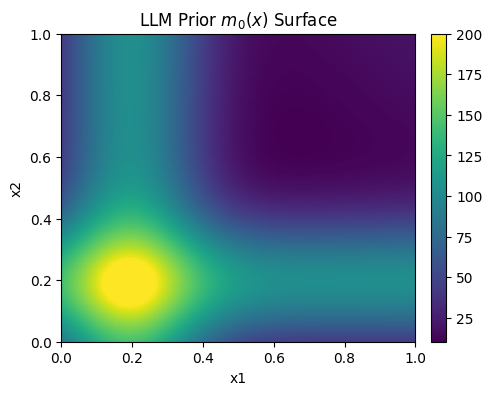

[iter  1] source=llm       align=+1.00 alpha_ls=+0.00 alpha_eff=+0.00 best=0.6662


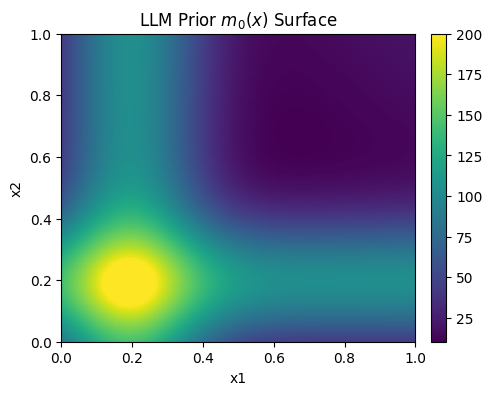

[iter  2] source=llm       align=+0.96 alpha_ls=+0.00 alpha_eff=+0.00 best=0.7847


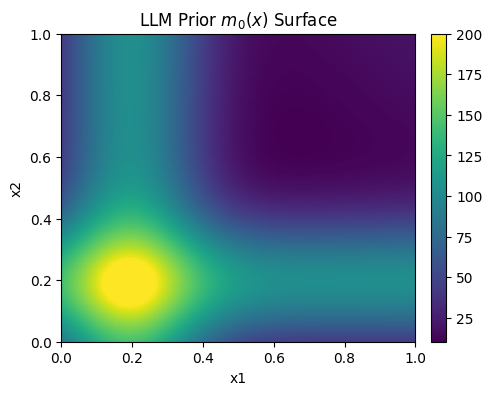

[iter  3] source=llm       align=+0.95 alpha_ls=+0.00 alpha_eff=+0.00 best=0.7847


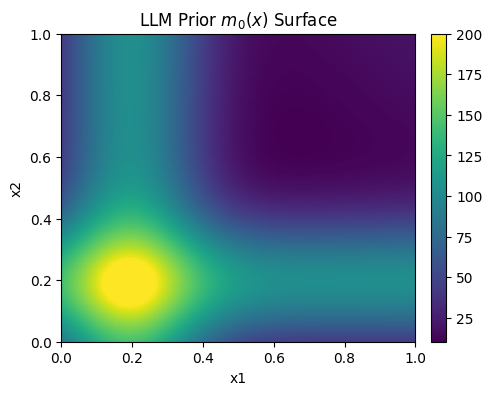

[iter  4] source=llm       align=+0.77 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8280


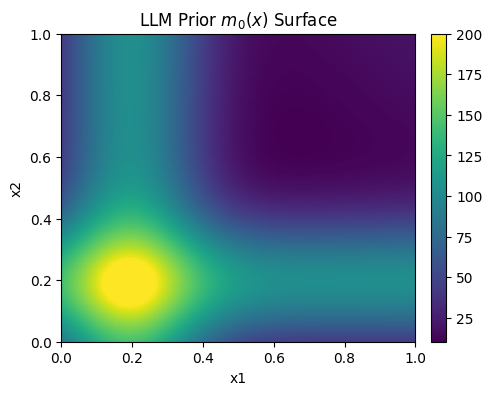

[iter  5] source=llm       align=+0.84 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8280


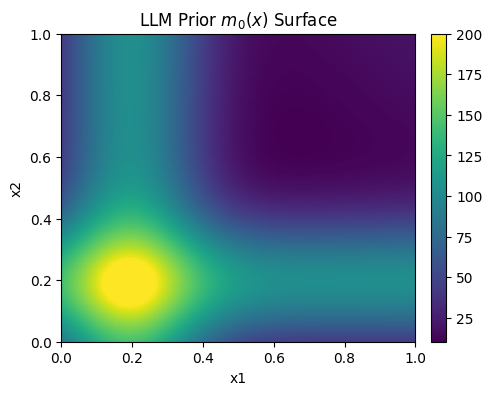

[iter  6] source=llm       align=+0.87 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8317


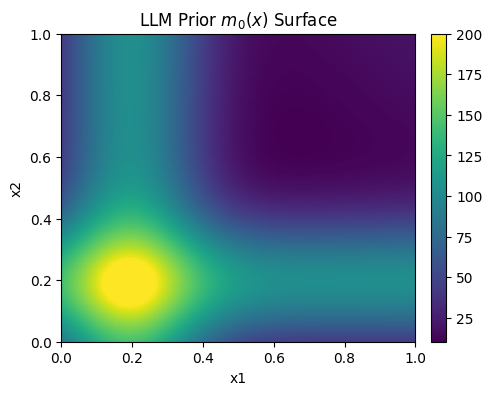

[iter  7] source=llm       align=+0.88 alpha_ls=+0.00 alpha_eff=+0.00 best=1.0939


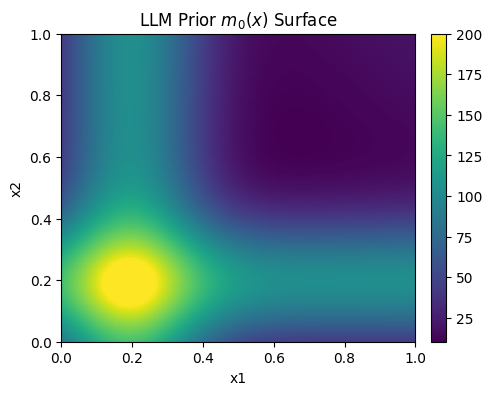

[iter  8] source=llm       align=+0.92 alpha_ls=+0.00 alpha_eff=+0.00 best=1.1284


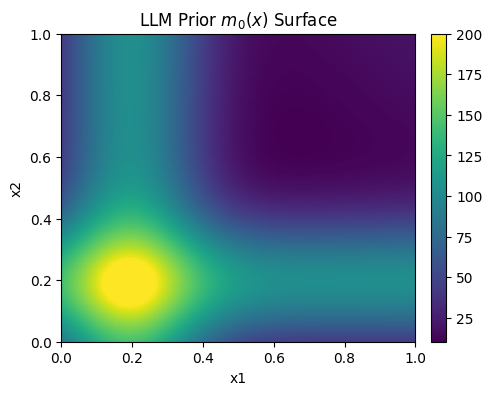

[iter  9] source=llm       align=+0.93 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2080


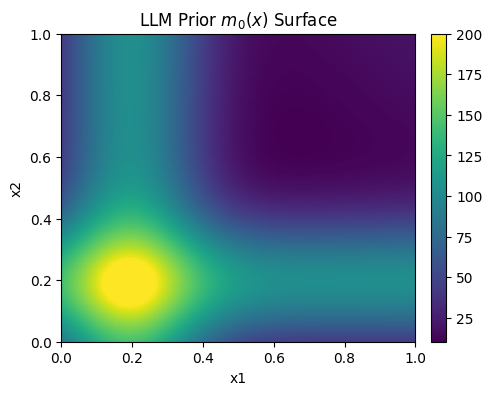

[iter 10] source=llm       align=+0.94 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2080


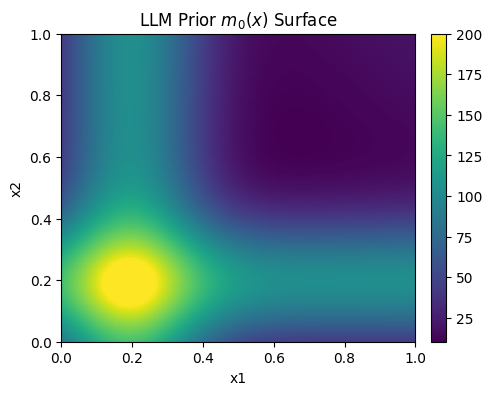

[iter 11] source=llm       align=+0.95 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2080


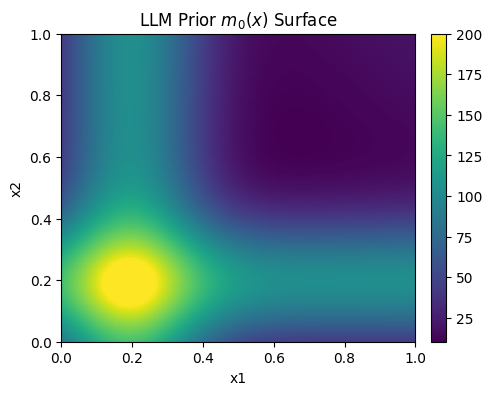

[iter 12] source=llm       align=+0.95 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2080


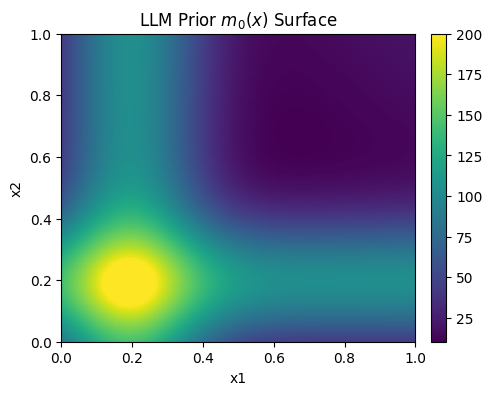

[iter 13] source=llm       align=+0.96 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2178


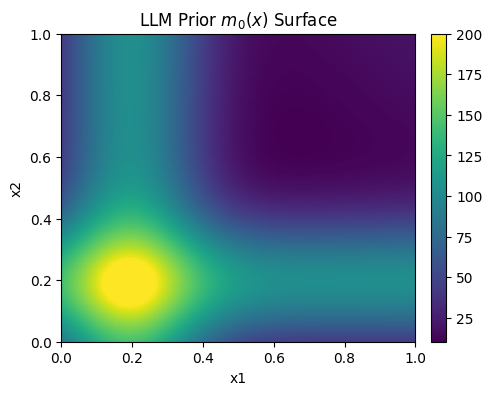

[iter 14] source=llm       align=+0.96 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2178


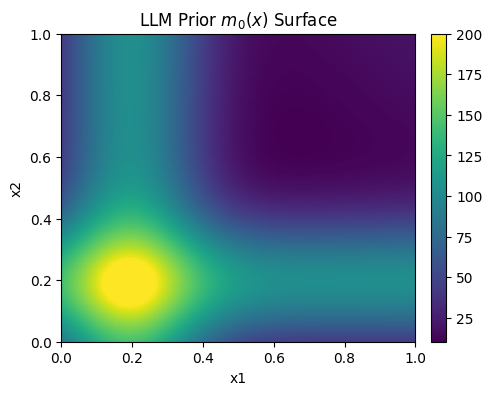

[iter 15] source=llm       align=+0.97 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2178


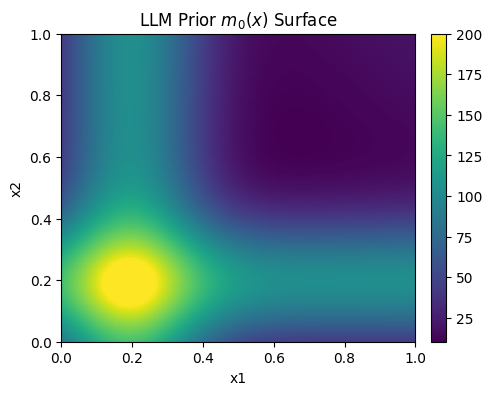

[iter 16] source=llm       align=+0.97 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2178


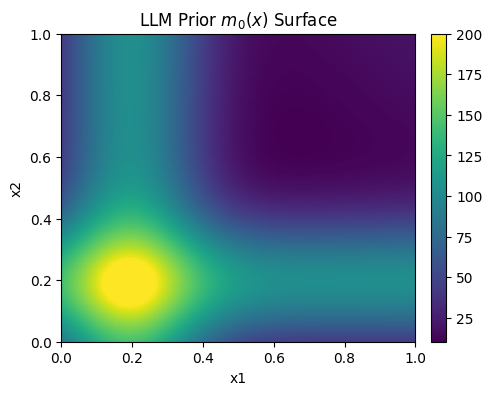

[iter 17] source=llm       align=+0.97 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2178


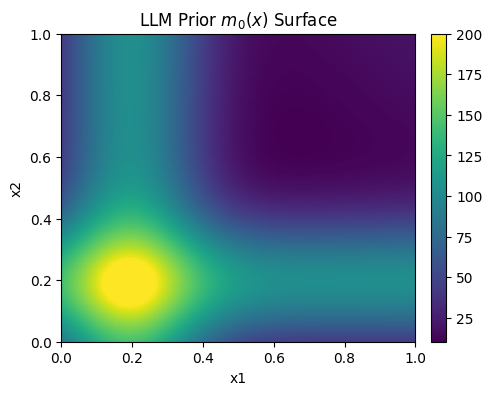

[iter 18] source=llm       align=+0.97 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2178


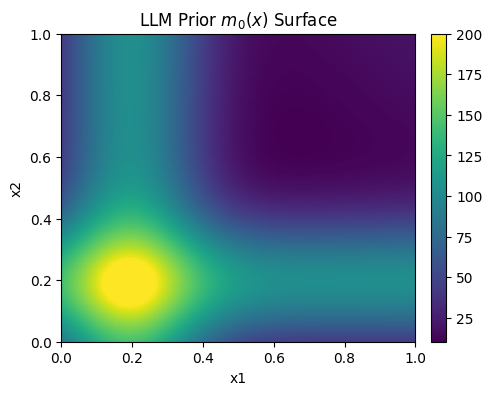

[iter 19] source=llm       align=+0.97 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2187


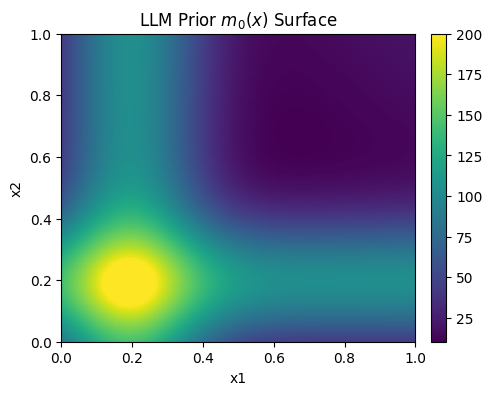

[iter 20] source=llm       align=+0.97 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2192


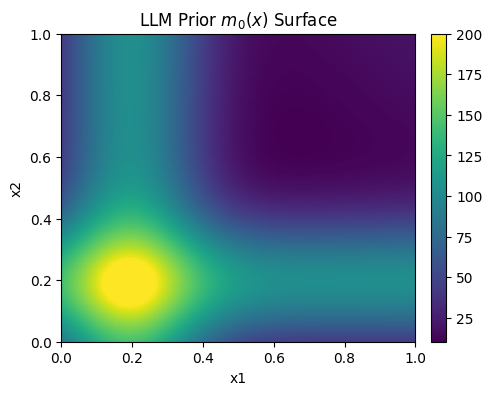

[iter  1] source=llm       align=+1.00 alpha_ls=+0.00 alpha_eff=+0.00 best=0.4408


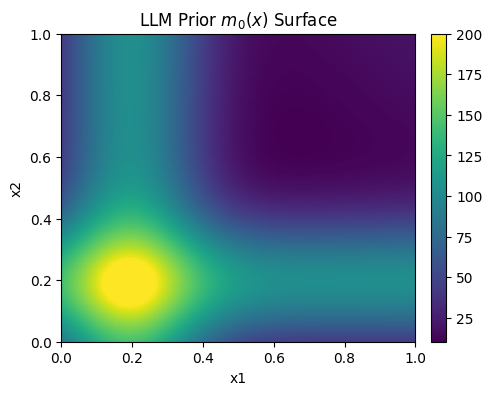

[iter  2] source=llm       align=+1.00 alpha_ls=+0.00 alpha_eff=+0.00 best=0.4408


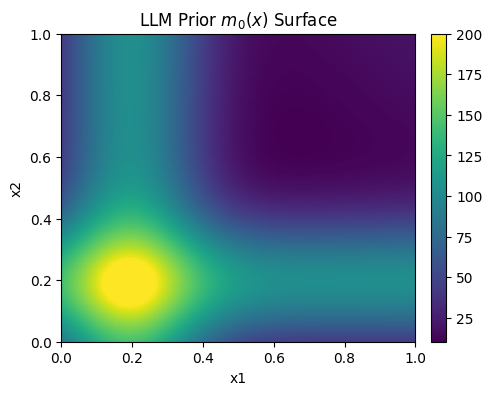

[iter  3] source=llm       align=+0.78 alpha_ls=+0.00 alpha_eff=+0.00 best=0.5440


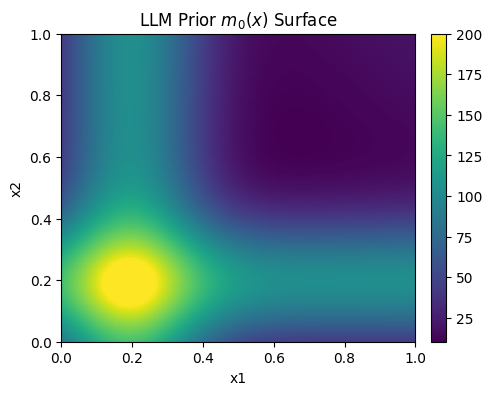

[iter  4] source=llm       align=+0.78 alpha_ls=+0.00 alpha_eff=+0.00 best=0.6259


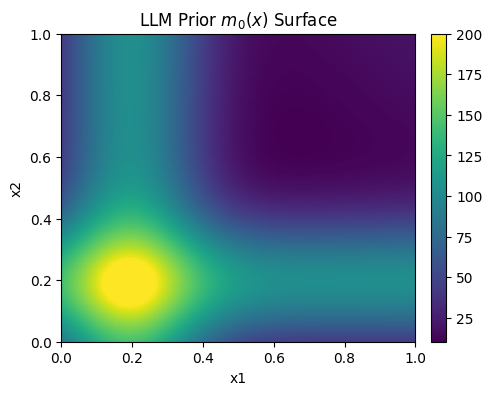

[iter  5] source=llm       align=+0.78 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8117


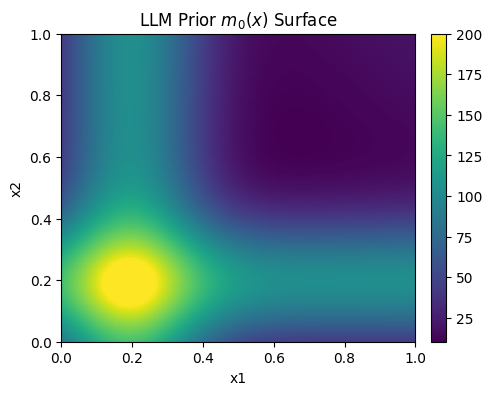

[iter  6] source=llm       align=+0.86 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8117


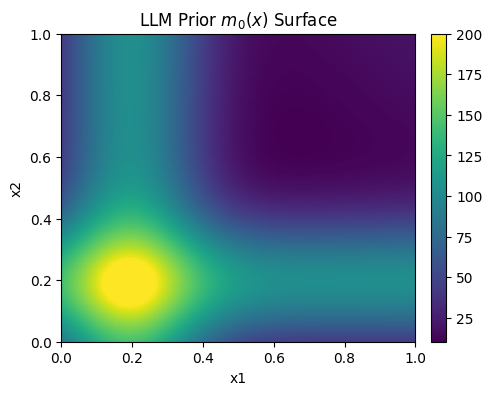

[iter  7] source=llm       align=+0.89 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8267


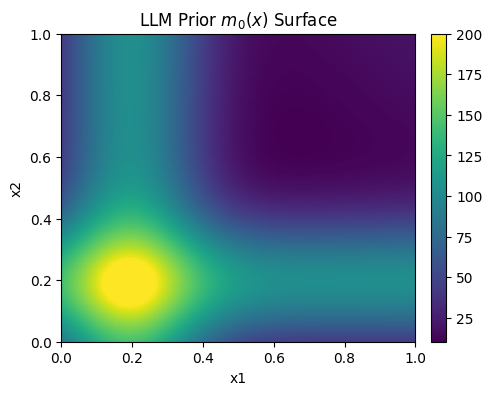

[iter  8] source=llm       align=+0.91 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8267


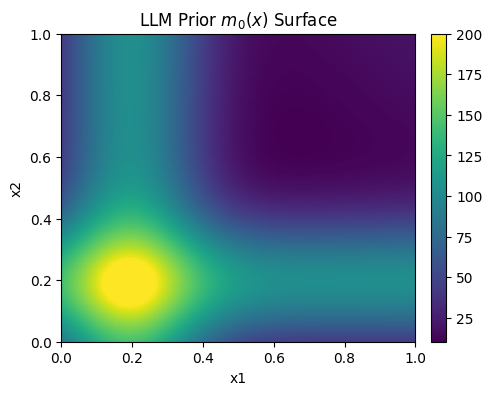

[iter  9] source=llm       align=+0.84 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8289


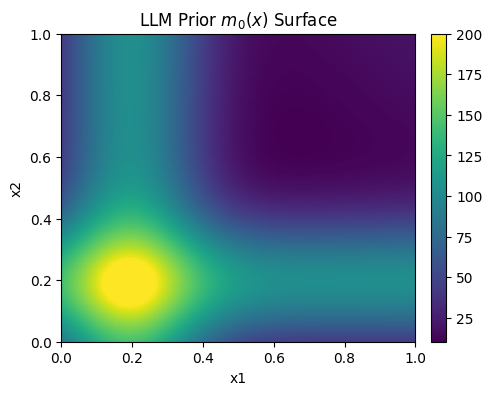

[iter 10] source=llm       align=+0.86 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8301


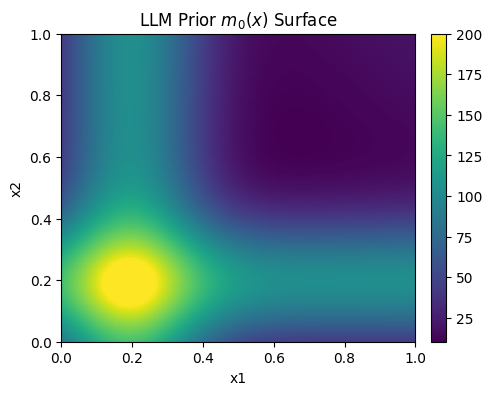

[iter 11] source=llm       align=+0.87 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8311


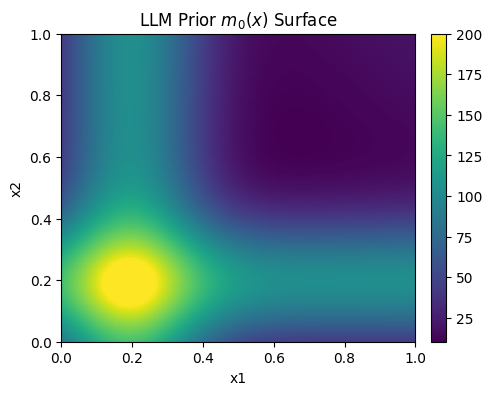

[iter 12] source=llm       align=+0.88 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8318


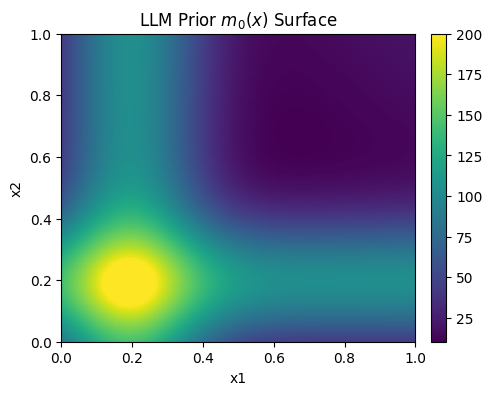

[iter 13] source=llm       align=+0.88 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8318


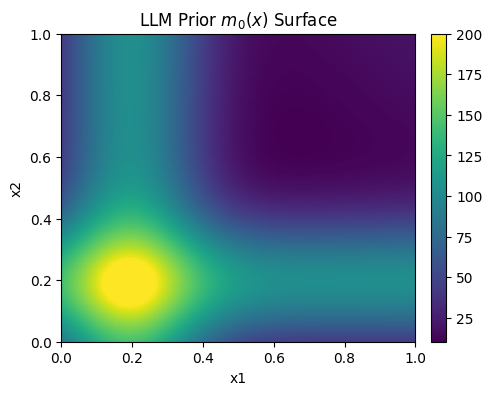

[iter 14] source=llm       align=+0.90 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8318


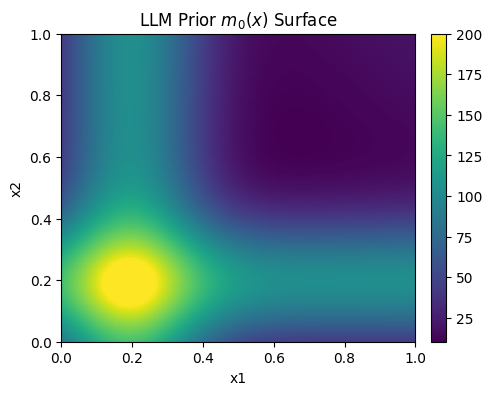

[iter 15] source=llm       align=+0.90 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8318


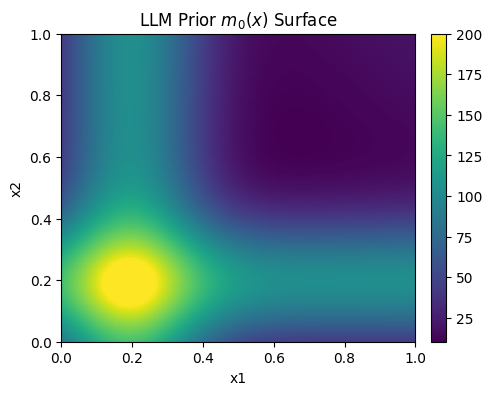

[iter 16] source=llm       align=+0.90 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8318


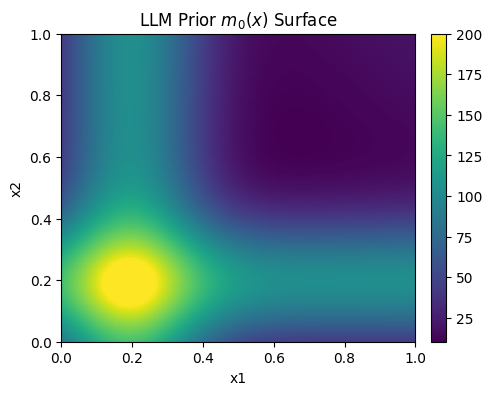

[iter 17] source=llm       align=+0.92 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8318


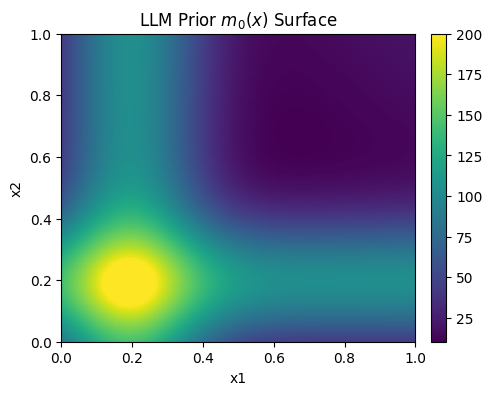

[iter 18] source=llm       align=+0.92 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8318


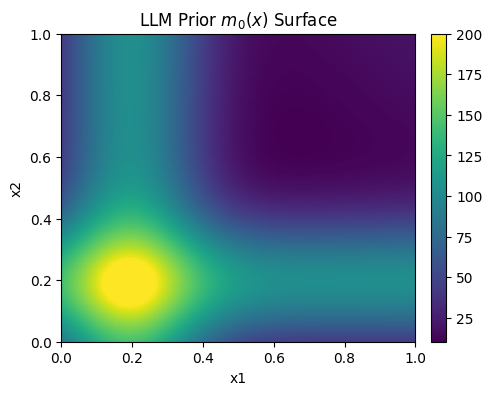

[iter 19] source=llm       align=+0.92 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8318


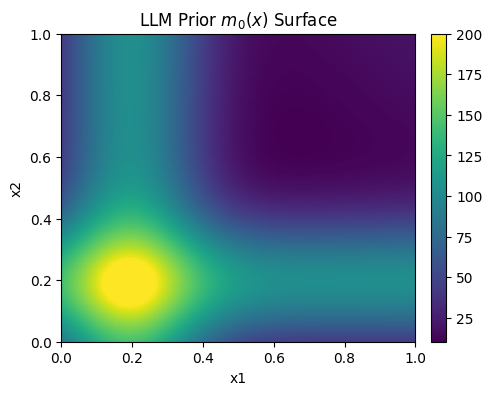

[iter 20] source=llm       align=+0.94 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8900


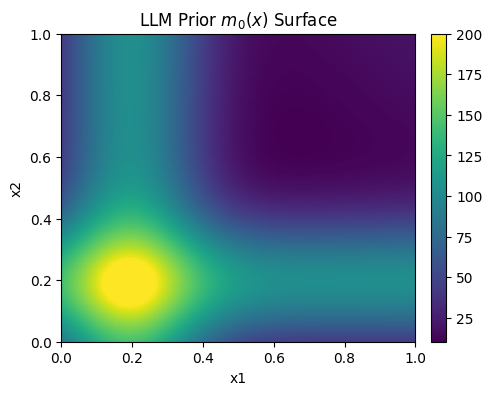

[iter  1] source=llm       align=+1.00 alpha_ls=+0.00 alpha_eff=+0.00 best=0.6661


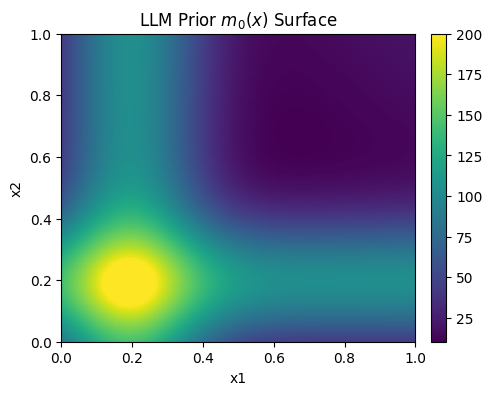

[iter  2] source=llm       align=+0.92 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8314


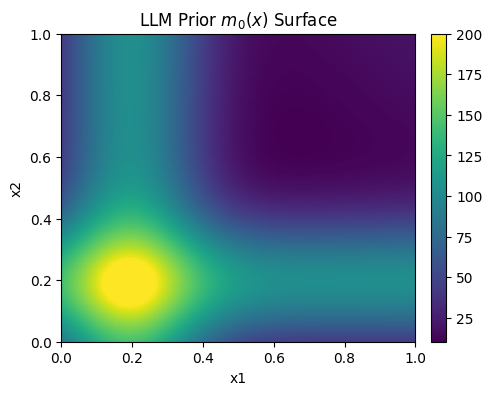

[iter  3] source=llm       align=+0.96 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8314


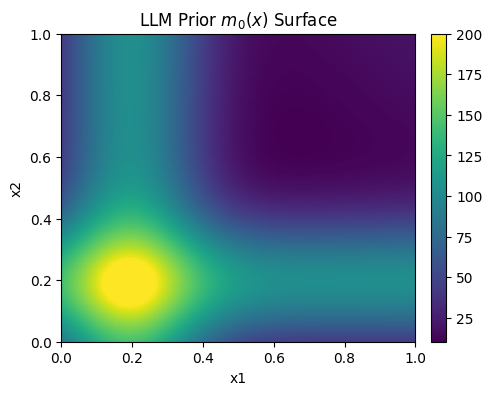

[iter  4] source=llm       align=+0.92 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8314


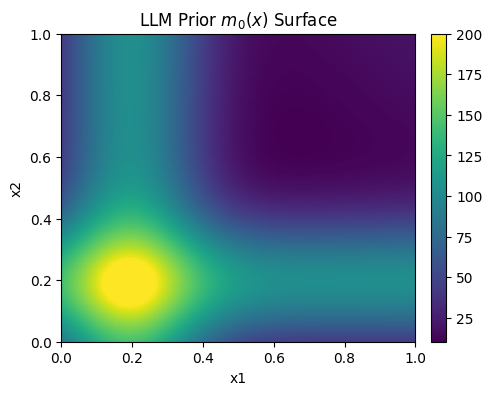

[iter  5] source=llm       align=+0.81 alpha_ls=+0.00 alpha_eff=+0.00 best=0.8314


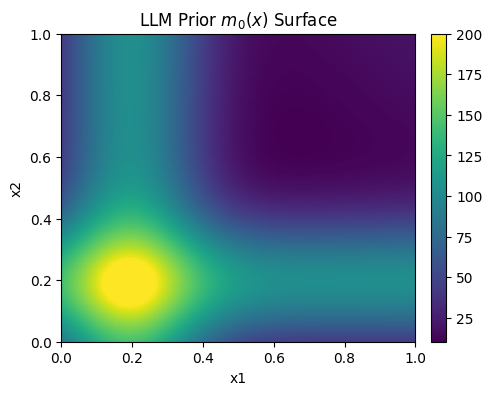

[iter  6] source=llm       align=+0.79 alpha_ls=+0.00 alpha_eff=+0.00 best=0.9250


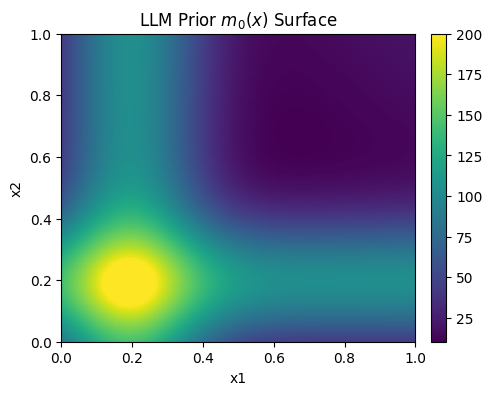

[iter  7] source=llm       align=+0.83 alpha_ls=+0.00 alpha_eff=+0.00 best=1.0513


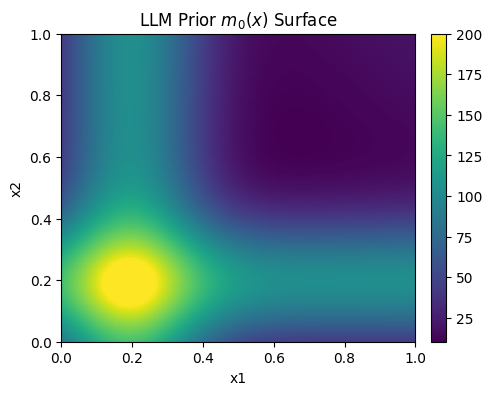

[iter  8] source=llm       align=+0.87 alpha_ls=+0.00 alpha_eff=+0.00 best=1.0513


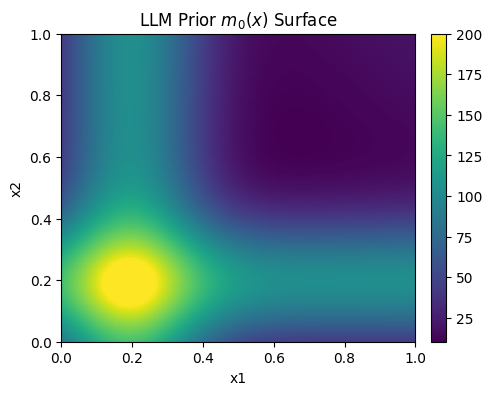

[iter  9] source=llm       align=+0.87 alpha_ls=+0.00 alpha_eff=+0.00 best=1.0513


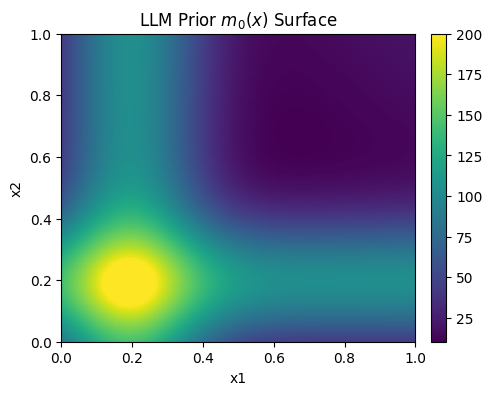

[iter 10] source=llm       align=+0.90 alpha_ls=+0.00 alpha_eff=+0.00 best=1.0513


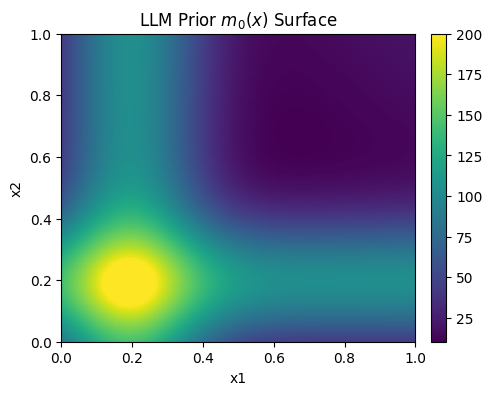

[iter 11] source=llm       align=+0.90 alpha_ls=+0.00 alpha_eff=+0.00 best=1.1885


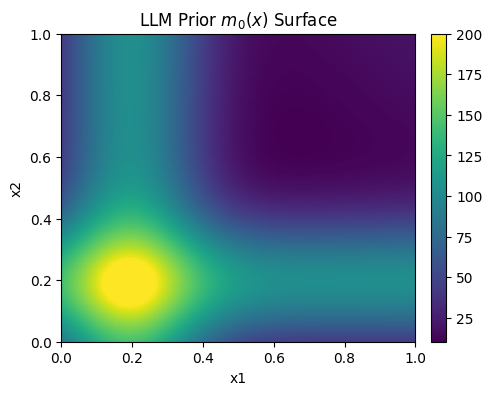

[iter 12] source=llm       align=+0.92 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2148


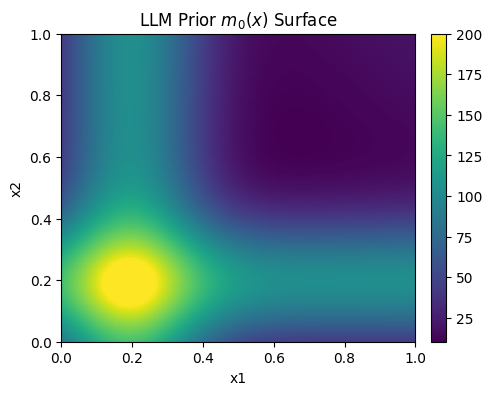

[iter 13] source=llm       align=+0.93 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2148


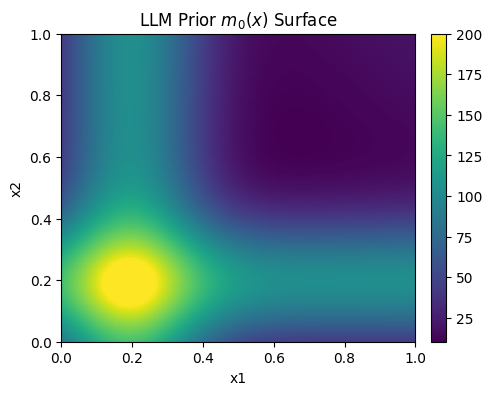

[iter 14] source=llm       align=+0.94 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2164


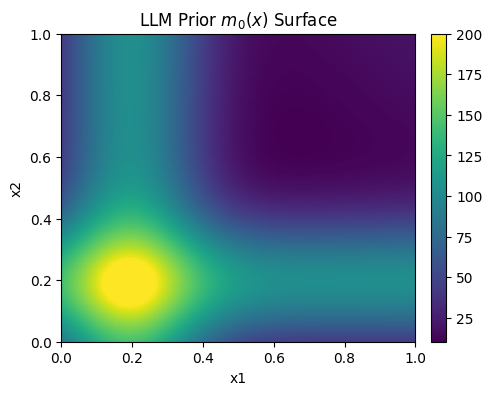

[iter 15] source=llm       align=+0.95 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2175


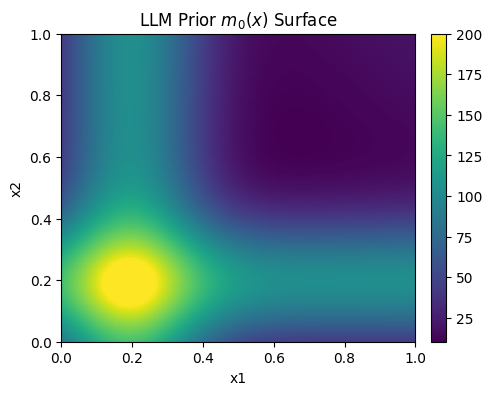

[iter 16] source=llm       align=+0.95 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2176


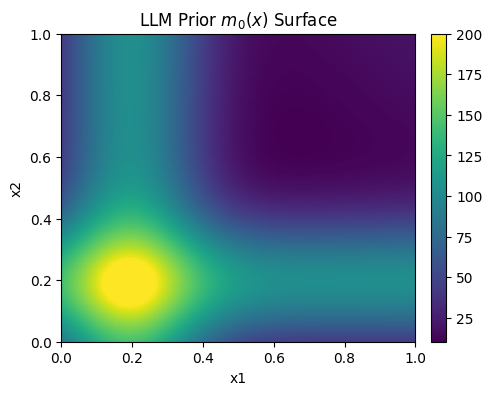

[iter 17] source=llm       align=+0.95 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2176


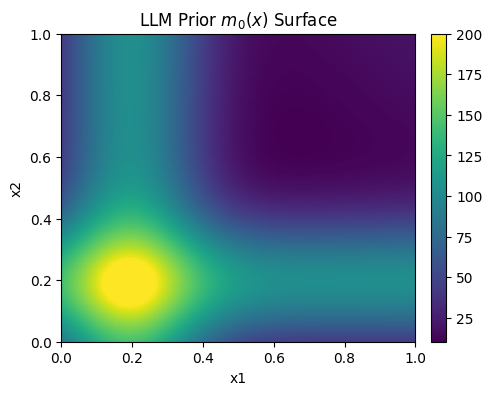

[iter 18] source=llm       align=+0.96 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2176


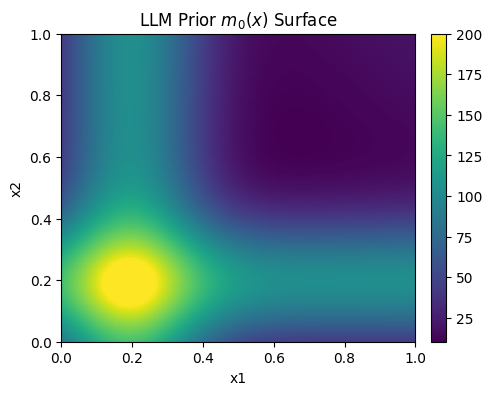

[iter 19] source=llm       align=+0.96 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2176


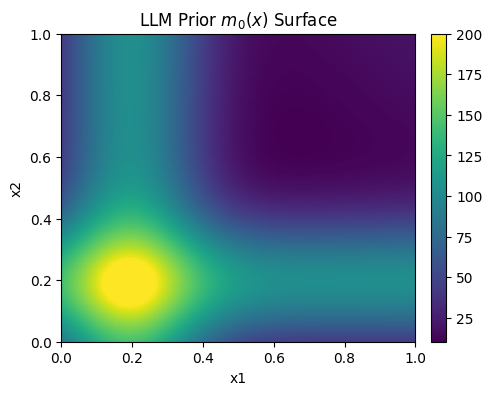

[iter 20] source=llm       align=+0.96 alpha_ls=+0.00 alpha_eff=+0.00 best=1.2176


In [131]:
# When calling run_benchmark, use these safer parameters:
df = run_benchmark(
    seeds=[0,1,2],
    n_init=2,
    n_iter=20,
    require_llm=True,
    call_every_k=1,
    auto_rescale_prior=True,
    use_weighted_ei=True,
    wei_lambda=1.2,  # REDUCED from 1.2 to 0.5
    verbose=True
)

In [128]:
df.to_csv("out_data.csv")

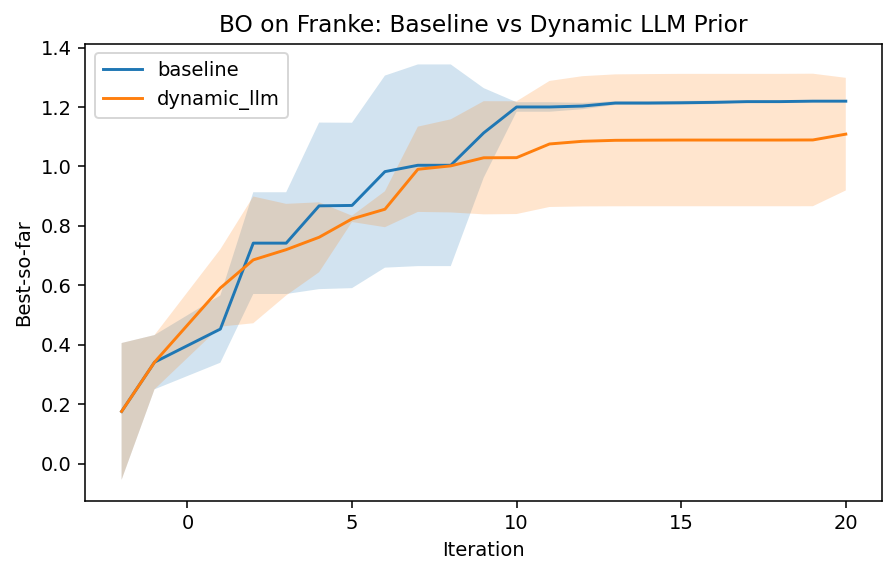

In [132]:
plot_runs_mean(df)

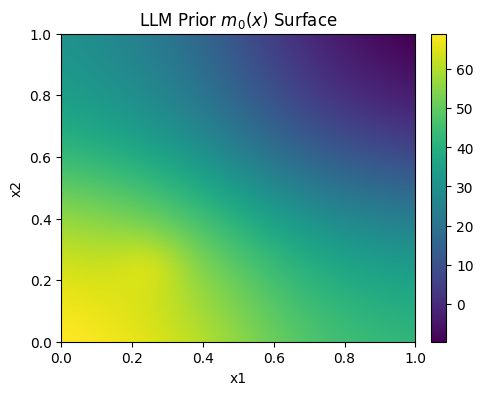

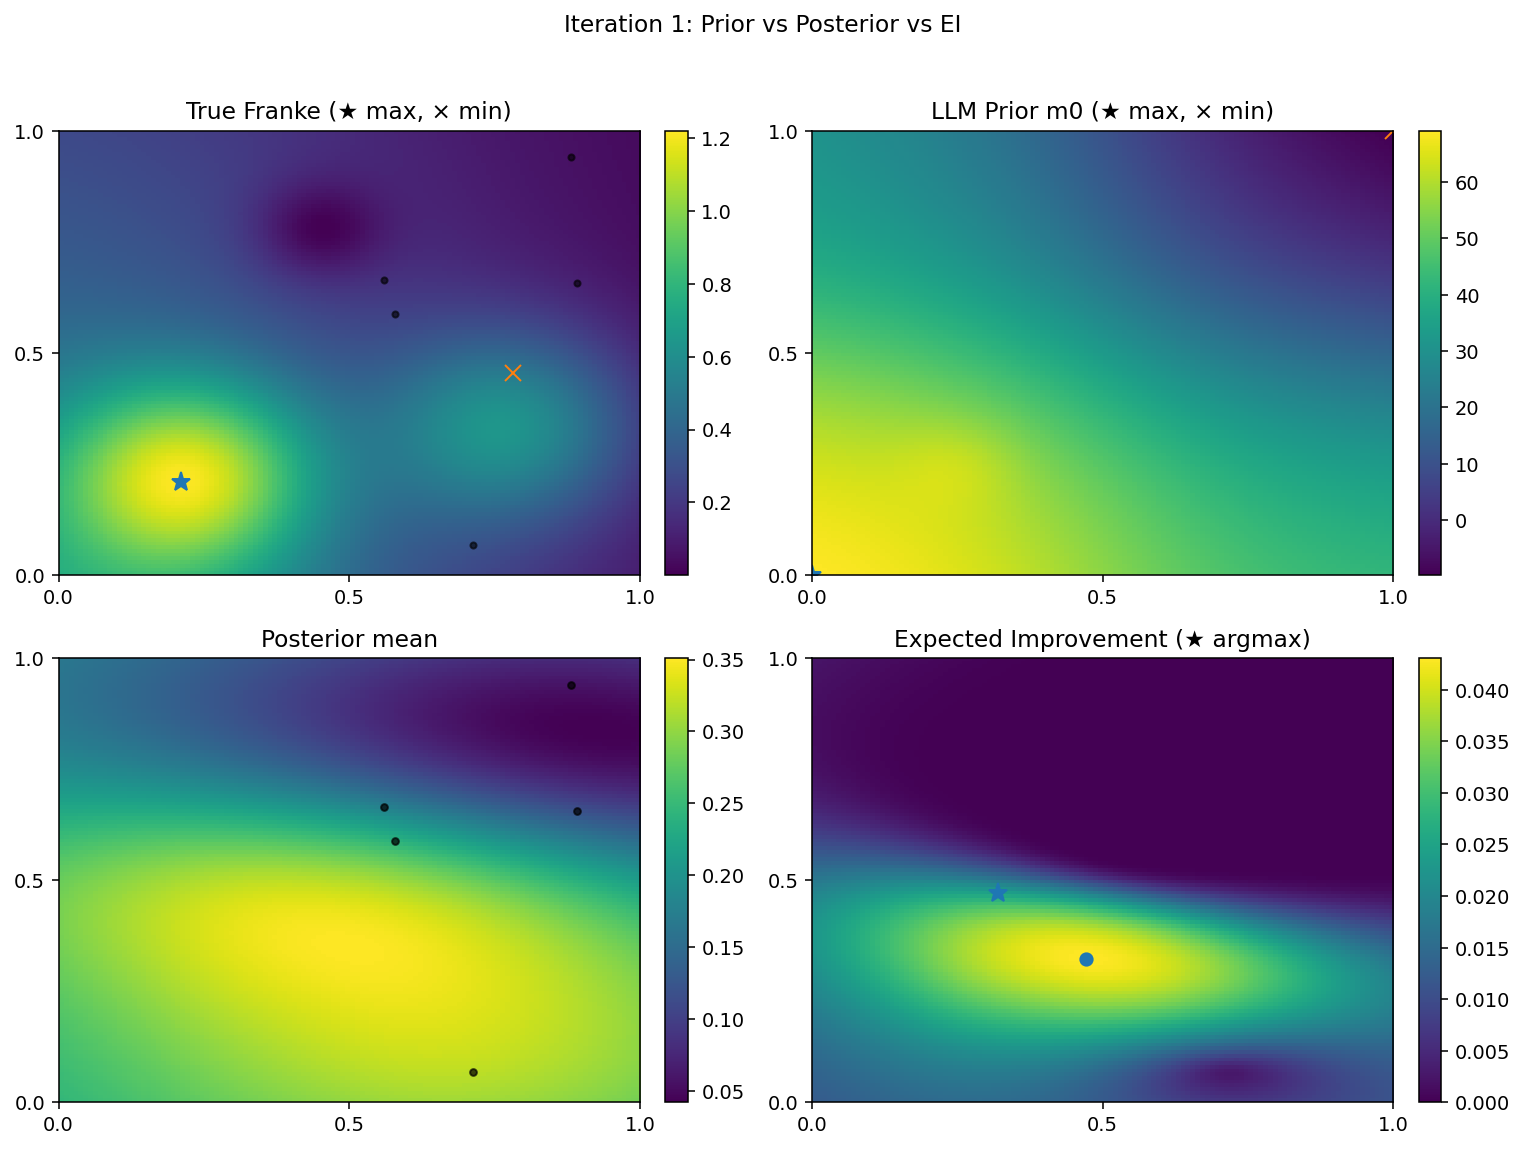

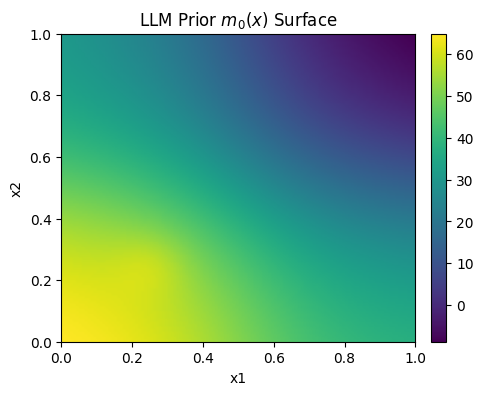

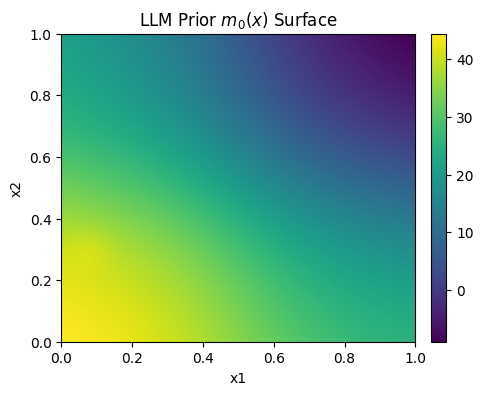

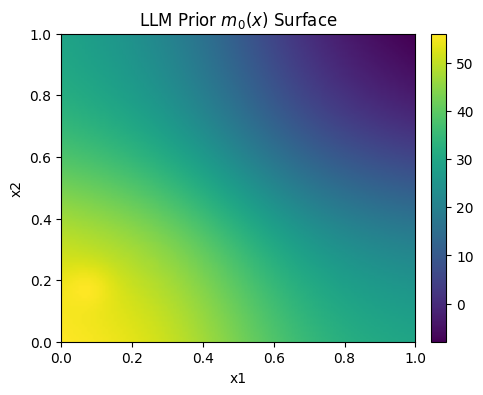

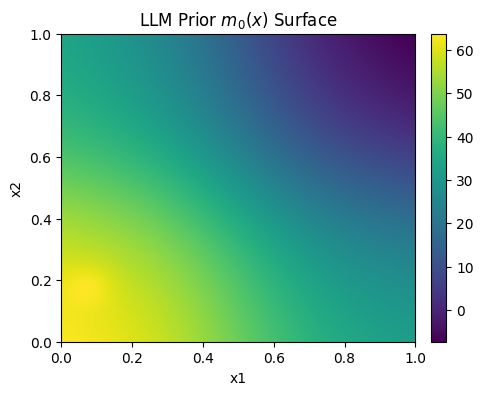

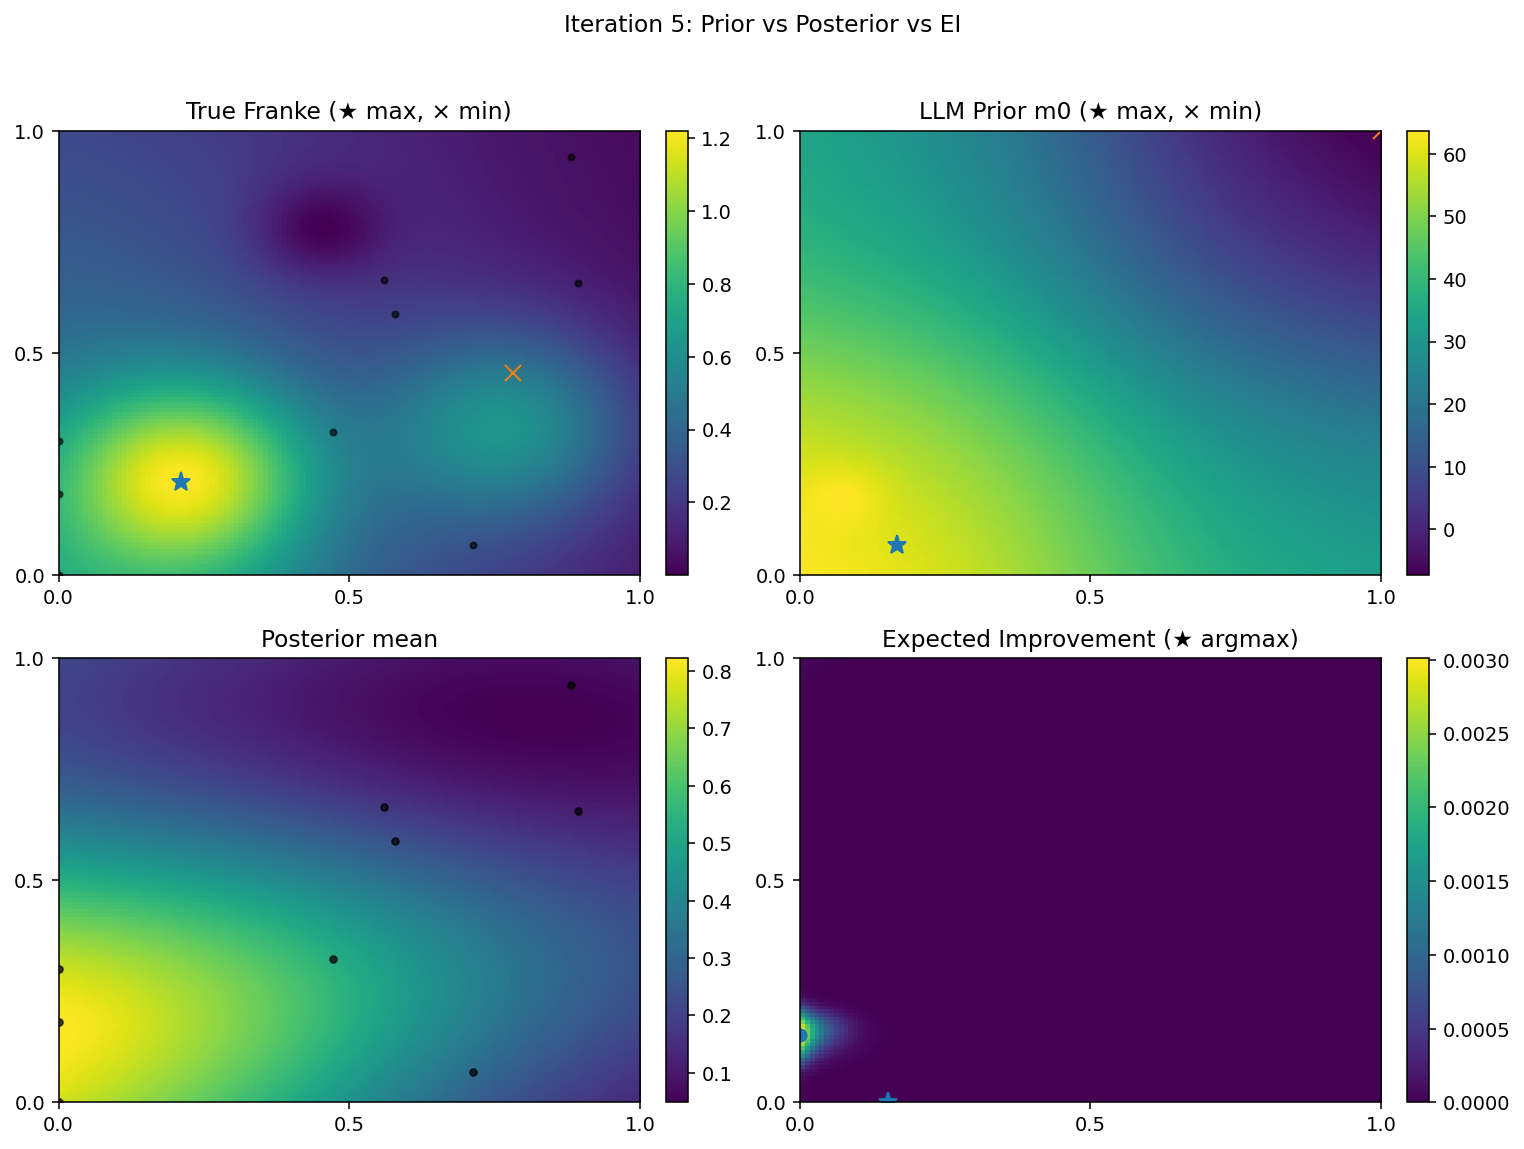

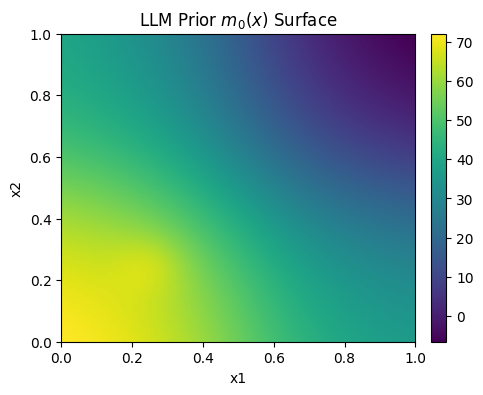

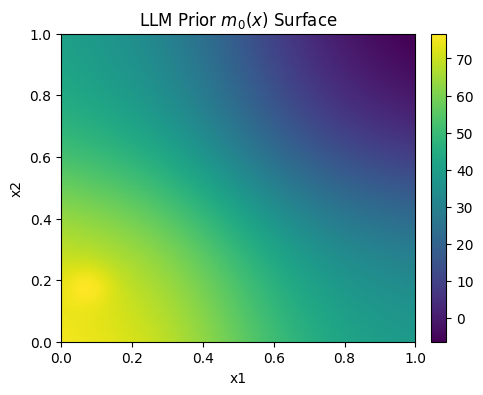

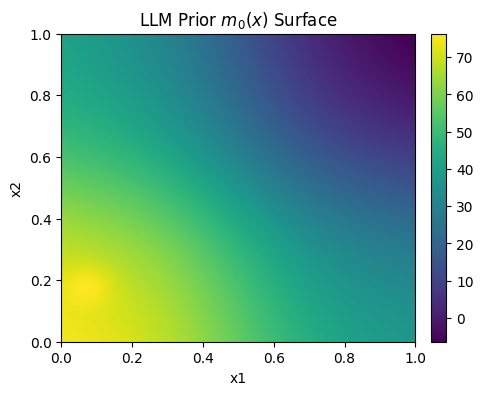

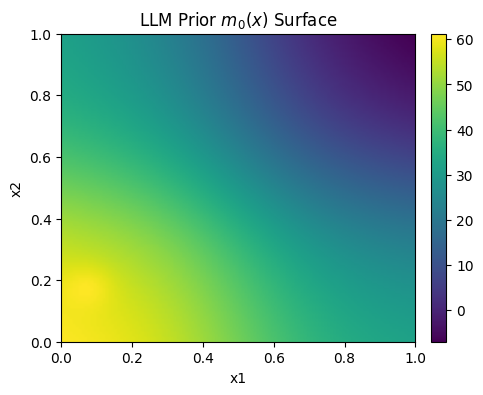

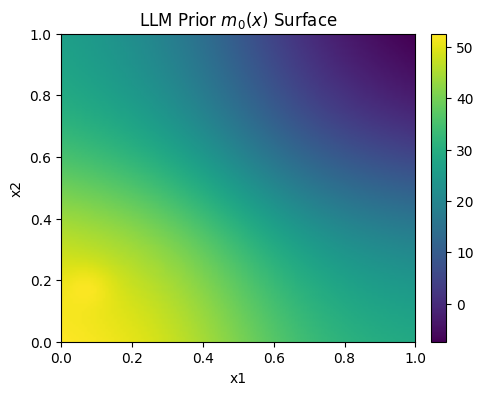

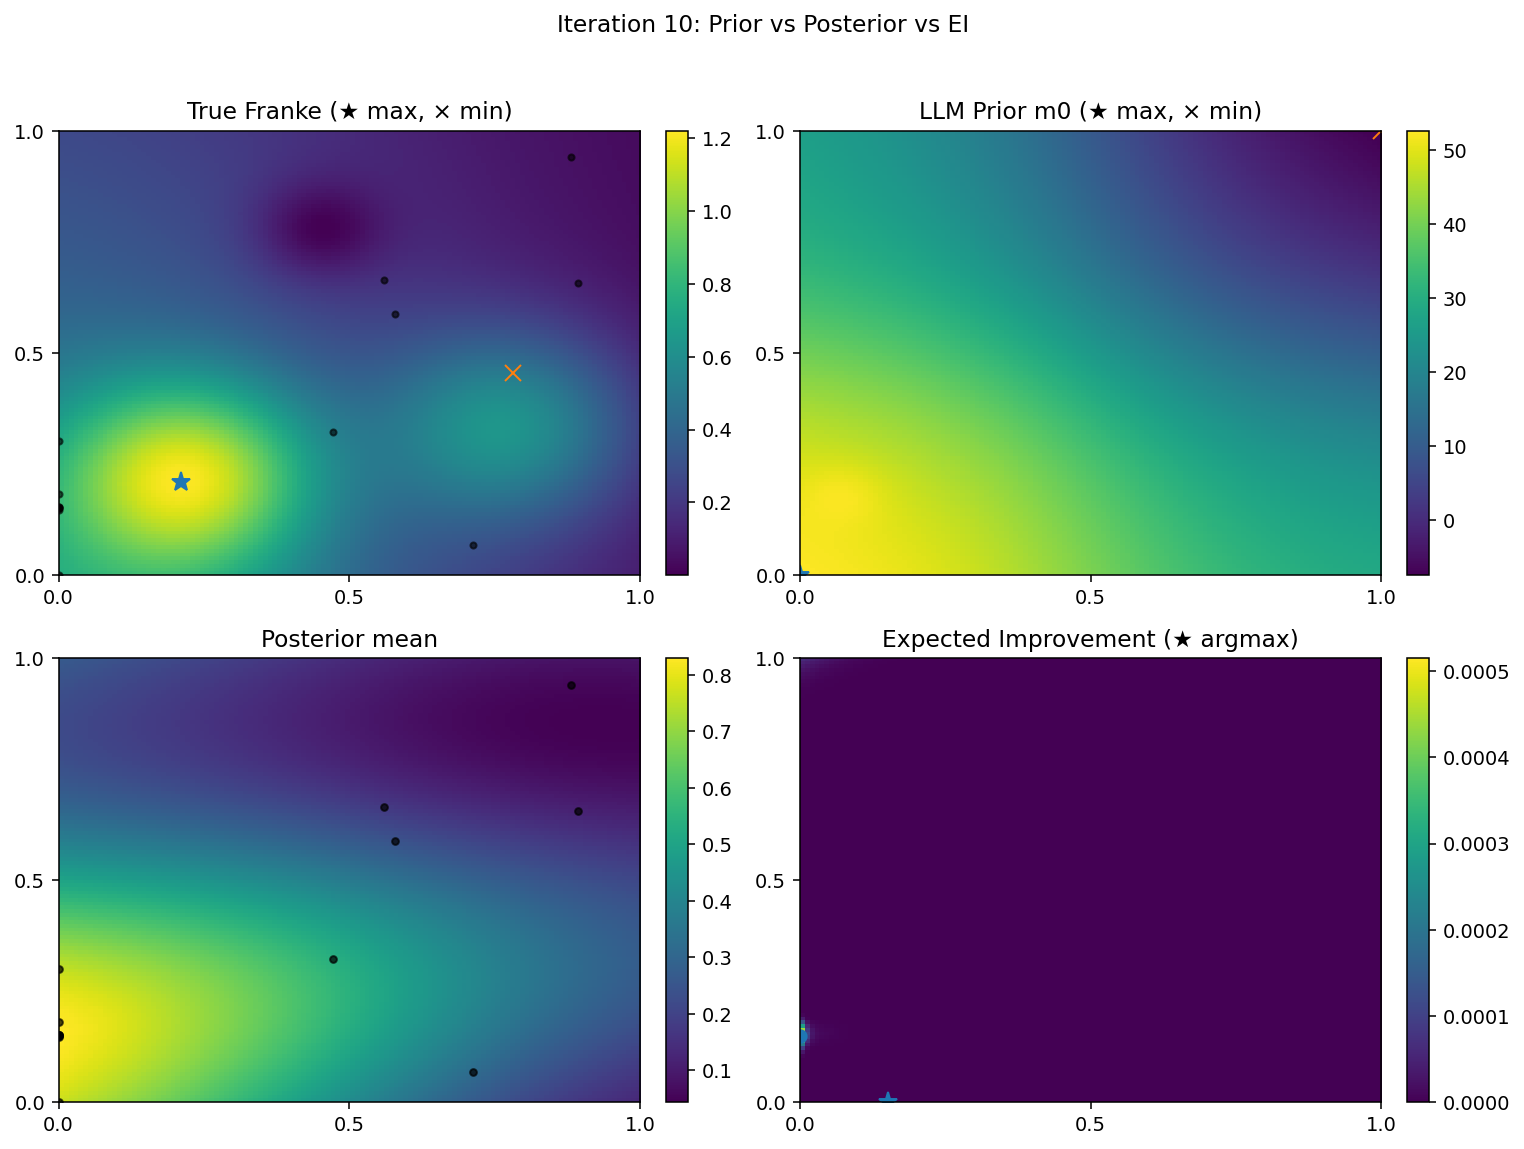

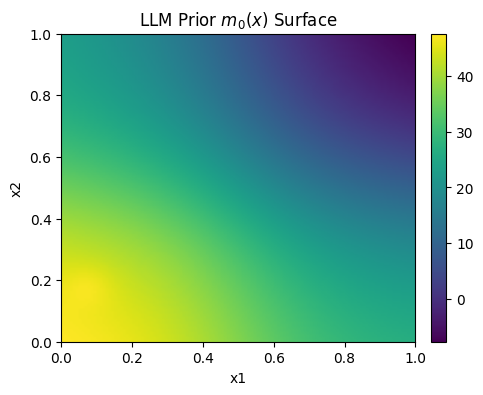

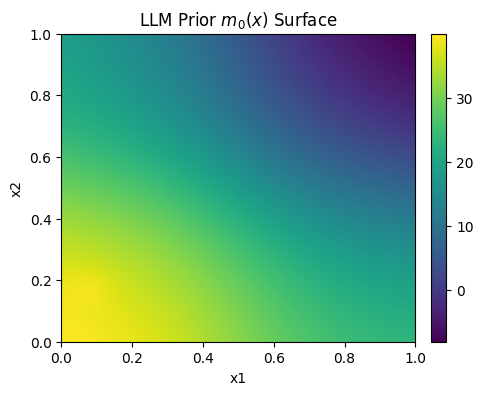

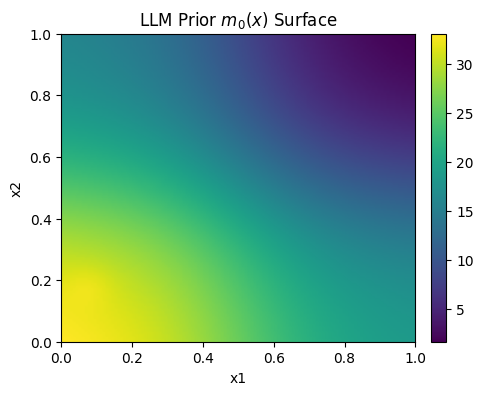

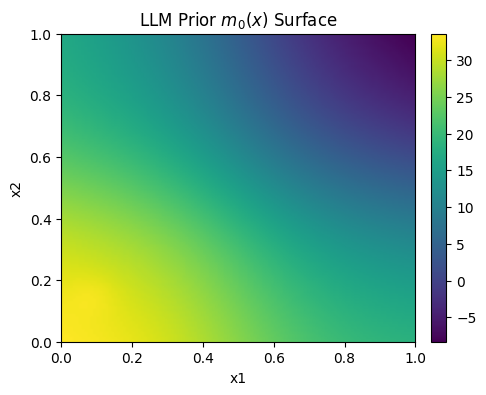

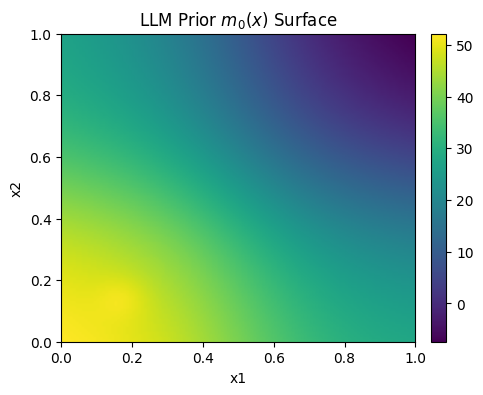

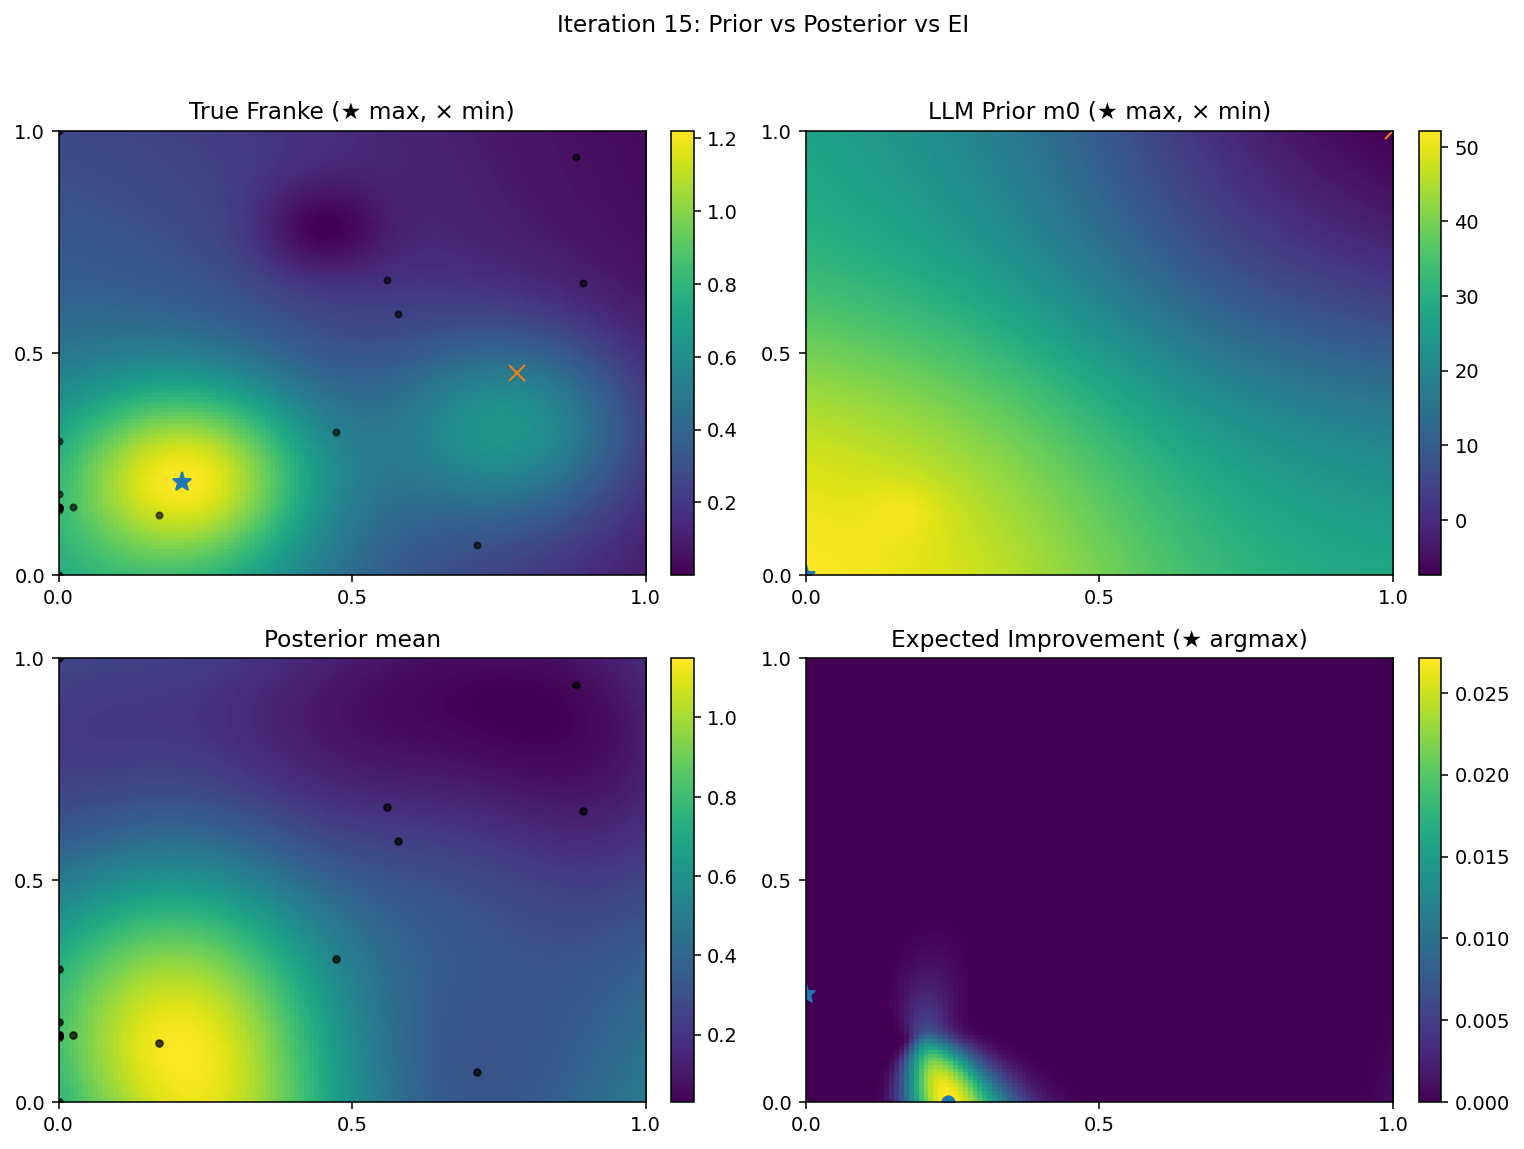

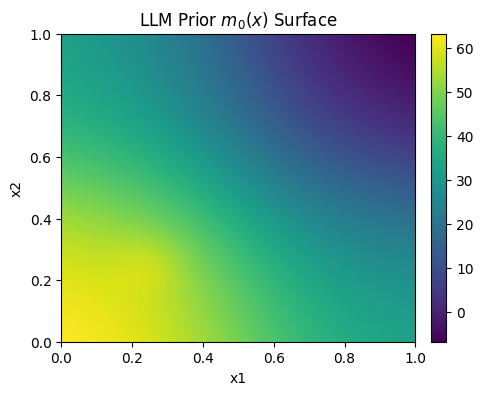

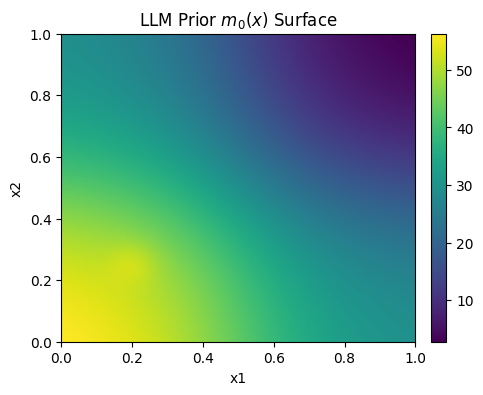

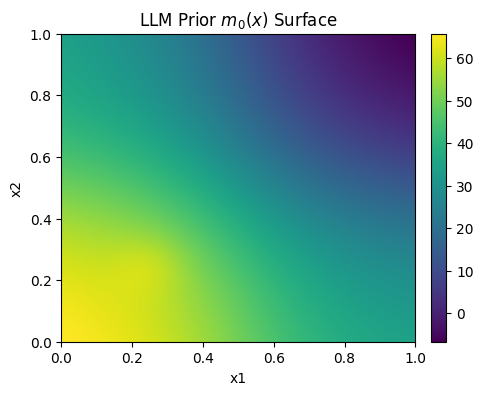

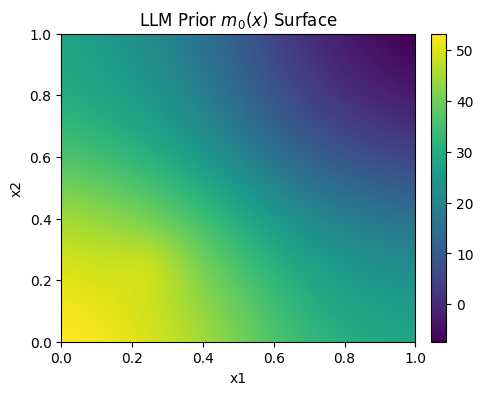

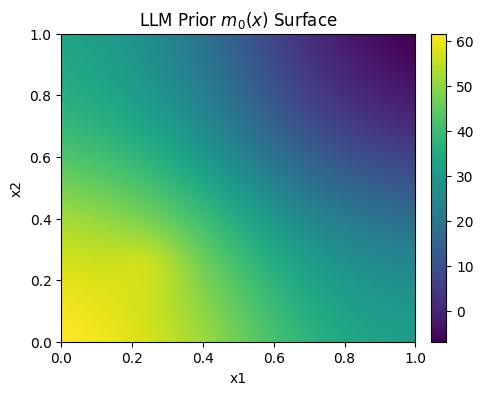

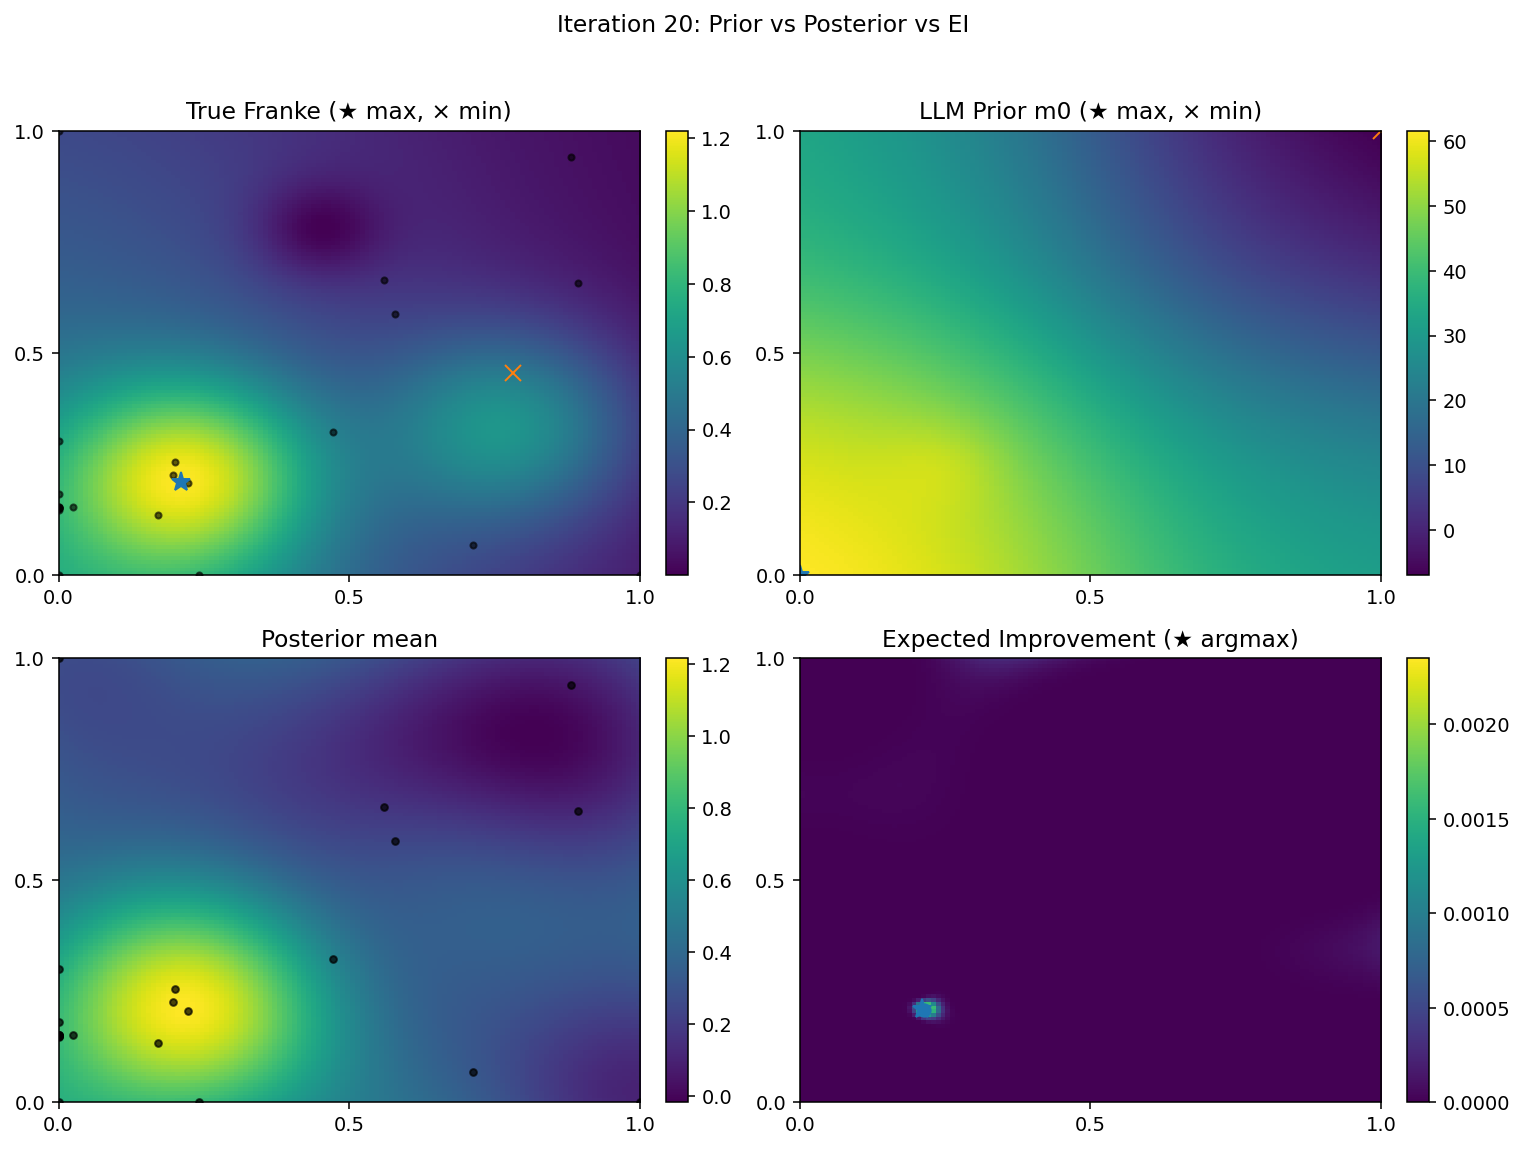

In [123]:



snap_iters = {1, 5, 10, 15, 20}
def viz_cb(t, X, y, prior, model, src, alpha_eff, x_next):
    if (t + 1) in snap_iters:
        plot_iteration_maps(X, y, prior, model, iter_idx=t+1,
                              x_next=x_next, alpha_eff=alpha_eff)

_ = bo_loop_dynamic_llm(seed=0, n_init=5, n_iter=20,
                          require_llm=True, verbose=False,
                          callback=viz_cb)

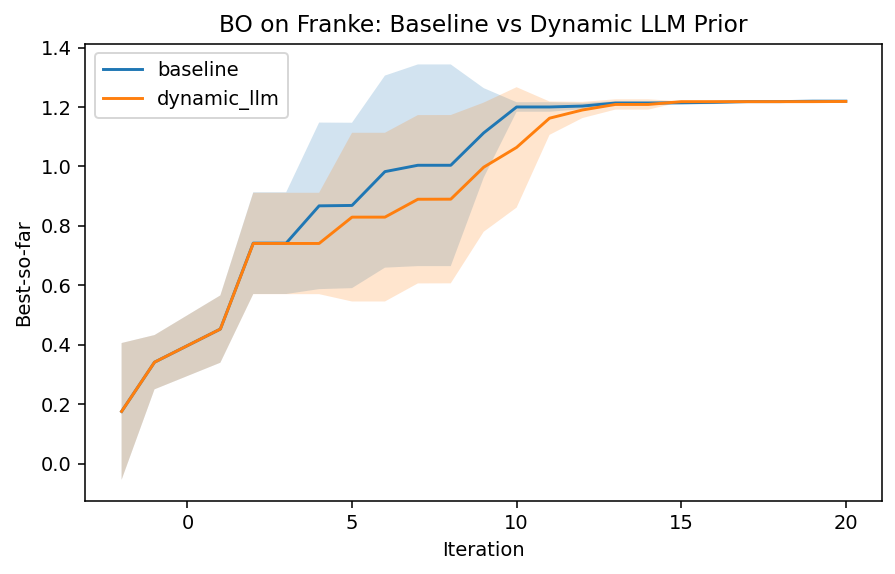

In [102]:
plot_runs_mean(df)